# SEIS 631 - Final Project - Group 4
Yue Cade \
Tony Challeen \
Siphosenkosi Mpofu \
Jason Shapiro \
Brian Susick

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA

Q1) Show me the market trends to help me decide. Which US real-estate market is doing best overall. -Jason

* Assumptions:
    * For general market trends, we're going to use smoothed/seasonal data to look at overall trends over a period of a year.
    * The housing market was affected by the pandemic causing unusual home selling/buying patterns, so we're going to focus on state from 2023 onwwards.
    * Although we will look at current state later in this work, we'll begin with looking at home value forecasts to get a general sense of which regional markets we want to focus in on.
    * Rationale for focusing on forecasts for this question:
        * The underlying question here is "which market should I focus on for future profits"
        * Zillow's ZHVF methodology includes their own data with other "macroeconomic factors" (mortgage rates, economic health, etc.) that wouldn't be taken in by just creating a regression from historical housing prices
    

In [2]:
# Load the data

# Zillow Home Value Forecast (ZHVF): 
# Each numerical value represents the projected percentage change. 
# Example: 0.2 = 0.2% increase; -0.2 = 0.2% decrease in home values

df = pd.read_csv("data/Metro_zhvf_growth_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")

display(df.head(5))  
display(df.tail(5))
display(df.count())

,RegionID,SizeRank,RegionName,RegionType,StateName,BaseDate,2024-11-30,2025-01-31,2025-10-31
0,102001,0,United States,country,NaN,2024-10-31,0.2,0.6,2.9
1,394913,1,"New York, NY",msa,NY,2024-10-31,0.3,0.5,1.5
2,753899,2,"Los Angeles, CA",msa,CA,2024-10-31,0.2,0.4,2.3
3,394463,3,"Chicago, IL",msa,IL,2024-10-31,0.1,0.2,1.1
4,394514,4,"Dallas, TX",msa,TX,2024-10-31,-0.2,-0.7,1.2


,RegionID,SizeRank,RegionName,RegionType,StateName,BaseDate,2024-11-30,2025-01-31,2025-10-31
890,753929,935,"Zapata, TX",msa,TX,2024-10-31,-0.8,-2.6,-7.2
891,394743,936,"Ketchikan, AK",msa,AK,2024-10-31,0.2,0.1,-0.9
892,753874,937,"Craig, CO",msa,CO,2024-10-31,0.4,1.0,4.4
893,395188,938,"Vernon, TX",msa,TX,2024-10-31,-1.4,-2.2,-4.3
894,394767,939,"Lamesa, TX",msa,TX,2024-10-31,-0.2,-0.7,-4.5


RegionID      895
SizeRank      895
RegionName    895
RegionType    895
StateName     894
BaseDate      895
2024-11-30    895
2025-01-31    895
2025-10-31    895
dtype: int64

In [3]:
# List number of rows
print("Before: number of rows: ", df.shape)
 
# Drop the duplicates - (no duplicates found)
df = df.drop_duplicates()
print("After: number of rows: ", df.shape)
 
# Drop Missing/Null Values (no null values found)
print("Sum of null values: ", df.isnull().sum())

# Drop rows with NaN values
display(df.count())
df = df.dropna() 
display(df.count())

display(df.head(5))
display(df.tail(5))

# This data is exceptionally clean - we only needed to drop the 1st row which isn't at the state level

Before: number of rows:  (895, 9)
After: number of rows:  (895, 9)
Sum of null values:  RegionID      0
SizeRank      0
RegionName    0
RegionType    0
StateName     1
BaseDate      0
2024-11-30    0
2025-01-31    0
2025-10-31    0
dtype: int64


RegionID      895
SizeRank      895
RegionName    895
RegionType    895
StateName     894
BaseDate      895
2024-11-30    895
2025-01-31    895
2025-10-31    895
dtype: int64

RegionID      894
SizeRank      894
RegionName    894
RegionType    894
StateName     894
BaseDate      894
2024-11-30    894
2025-01-31    894
2025-10-31    894
dtype: int64

,RegionID,SizeRank,RegionName,RegionType,StateName,BaseDate,2024-11-30,2025-01-31,2025-10-31
1,394913,1,"New York, NY",msa,NY,2024-10-31,0.3,0.5,1.5
2,753899,2,"Los Angeles, CA",msa,CA,2024-10-31,0.2,0.4,2.3
3,394463,3,"Chicago, IL",msa,IL,2024-10-31,0.1,0.2,1.1
4,394514,4,"Dallas, TX",msa,TX,2024-10-31,-0.2,-0.7,1.2
5,394692,5,"Houston, TX",msa,TX,2024-10-31,-0.2,-0.6,0.6


,RegionID,SizeRank,RegionName,RegionType,StateName,BaseDate,2024-11-30,2025-01-31,2025-10-31
890,753929,935,"Zapata, TX",msa,TX,2024-10-31,-0.8,-2.6,-7.2
891,394743,936,"Ketchikan, AK",msa,AK,2024-10-31,0.2,0.1,-0.9
892,753874,937,"Craig, CO",msa,CO,2024-10-31,0.4,1.0,4.4
893,395188,938,"Vernon, TX",msa,TX,2024-10-31,-1.4,-2.2,-4.3
894,394767,939,"Lamesa, TX",msa,TX,2024-10-31,-0.2,-0.7,-4.5


In [4]:
# Rename column headers to snake_case and more appropriate terms
df = df.rename(columns={"RegionID": "region_id", 
                        "SizeRank": "size_rank", 
                        "RegionName": "metro_area",
                        "RegionType": "region_type",
                        "StateName": "state_name",
                        "BaseDate": "base_date", 
                        "2024-11-30": "month_ahead_forecast", 
                        "2025-01-31": "quarter_ahead_forecast", 
                        "2025-10-31": "year_ahead_forecast"})
df.head(5)

# View a couple of columns to confirm the suspicion that the data is redundant/repeated or simply not needed
display(df['region_type'].unique())
display(df['base_date'].unique())

# Drop unnecessary columns
df = df.drop(["region_id", "size_rank", "region_type", "base_date"], axis=1)
display(df.head(5))

array(['msa'], dtype=object)

array(['2024-10-31'], dtype=object)

,metro_area,state_name,month_ahead_forecast,quarter_ahead_forecast,year_ahead_forecast
1,"New York, NY",NY,0.3,0.5,1.5
2,"Los Angeles, CA",CA,0.2,0.4,2.3
3,"Chicago, IL",IL,0.1,0.2,1.1
4,"Dallas, TX",TX,-0.2,-0.7,1.2
5,"Houston, TX",TX,-0.2,-0.6,0.6


In [5]:
# Add a "Region" column

# Define the regions
northeast = ["CT", "ME", "MA", "NH", "RI", "VT", "NJ", "NY", "PA"]
midwest = ["IL", "IN", "IA", "KS", "MI", "MN", "MO", "NE", "ND", "OH", "SD", "WI"]
south = ["AL", "AR", "DE", "FL", "GA", "KY", "LA", "MD", "MS", "NC", "OK", "SC", "TN", "TX", "VA", "WV"]
west = ["AK", "AZ", "CA", "CO", "HI", "ID", "MT", "NV", "NM", "OR", "UT", "WA", "WY"]

# Map states to regions
region_map = {}
region_map.update({state: "northeast" for state in northeast})
region_map.update({state: "midwest" for state in midwest})
region_map.update({state: "south" for state in south})
region_map.update({state: "west" for state in west})

display(region_map)

# Add the Region column
df.insert(2, "region", df["state_name"].map(region_map))

df.head(5)


{'CT': 'northeast',
 'ME': 'northeast',
 'MA': 'northeast',
 'NH': 'northeast',
 'RI': 'northeast',
 'VT': 'northeast',
 'NJ': 'northeast',
 'NY': 'northeast',
 'PA': 'northeast',
 'IL': 'midwest',
 'IN': 'midwest',
 'IA': 'midwest',
 'KS': 'midwest',
 'MI': 'midwest',
 'MN': 'midwest',
 'MO': 'midwest',
 'NE': 'midwest',
 'ND': 'midwest',
 'OH': 'midwest',
 'SD': 'midwest',
 'WI': 'midwest',
 'AL': 'south',
 'AR': 'south',
 'DE': 'south',
 'FL': 'south',
 'GA': 'south',
 'KY': 'south',
 'LA': 'south',
 'MD': 'south',
 'MS': 'south',
 'NC': 'south',
 'OK': 'south',
 'SC': 'south',
 'TN': 'south',
 'TX': 'south',
 'VA': 'south',
 'WV': 'south',
 'AK': 'west',
 'AZ': 'west',
 'CA': 'west',
 'CO': 'west',
 'HI': 'west',
 'ID': 'west',
 'MT': 'west',
 'NV': 'west',
 'NM': 'west',
 'OR': 'west',
 'UT': 'west',
 'WA': 'west',
 'WY': 'west'}

,metro_area,state_name,region,month_ahead_forecast,quarter_ahead_forecast,year_ahead_forecast
1,"New York, NY",NY,northeast,0.3,0.5,1.5
2,"Los Angeles, CA",CA,west,0.2,0.4,2.3
3,"Chicago, IL",IL,midwest,0.1,0.2,1.1
4,"Dallas, TX",TX,south,-0.2,-0.7,1.2
5,"Houston, TX",TX,south,-0.2,-0.6,0.6


In [6]:
# Calculate overall forecast
df['overall_forecast'] = df[['month_ahead_forecast', 'quarter_ahead_forecast', 'year_ahead_forecast']].mean(axis=1)

# Group by region and calculate mean forecasts
grouped_df = df.groupby('region').mean(numeric_only=True)
display(grouped_df)

,month_ahead_forecast,quarter_ahead_forecast,year_ahead_forecast,overall_forecast
region,,,,
midwest,0.242857,0.522344,2.251648,1.005617
northeast,0.182022,0.431461,2.943820,1.185768
south,-0.123184,-0.188547,1.452793,0.380354
west,0.069540,-0.016092,1.897701,0.650383


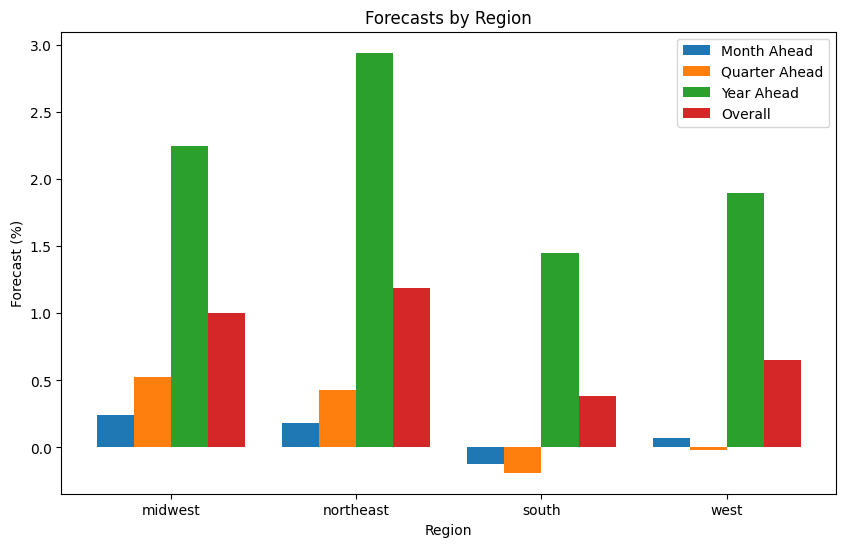

In [7]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Define bar width and positions
bar_width = 0.2
index = np.arange(len(grouped_df))

# Plot each forecast type
ax.bar(index, grouped_df['month_ahead_forecast'], bar_width, label='Month Ahead')
ax.bar(index + bar_width, grouped_df['quarter_ahead_forecast'], bar_width, label='Quarter Ahead')
ax.bar(index + bar_width * 2, grouped_df['year_ahead_forecast'], bar_width, label='Year Ahead')
ax.bar(index + bar_width * 3, grouped_df['overall_forecast'], bar_width, label='Overall')

# Set labels and title
ax.set_xlabel('Region')
ax.set_ylabel('Forecast (%)')
ax.set_title('Forecasts by Region')
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(grouped_df.index)
ax.legend()

# Show plot
plt.show()

## Bar Chart Conclusions
* Northeast has the most positive outlook for a year ahead and overall price increase
* Midwest has the most positive outlook for a month and quarter ahead

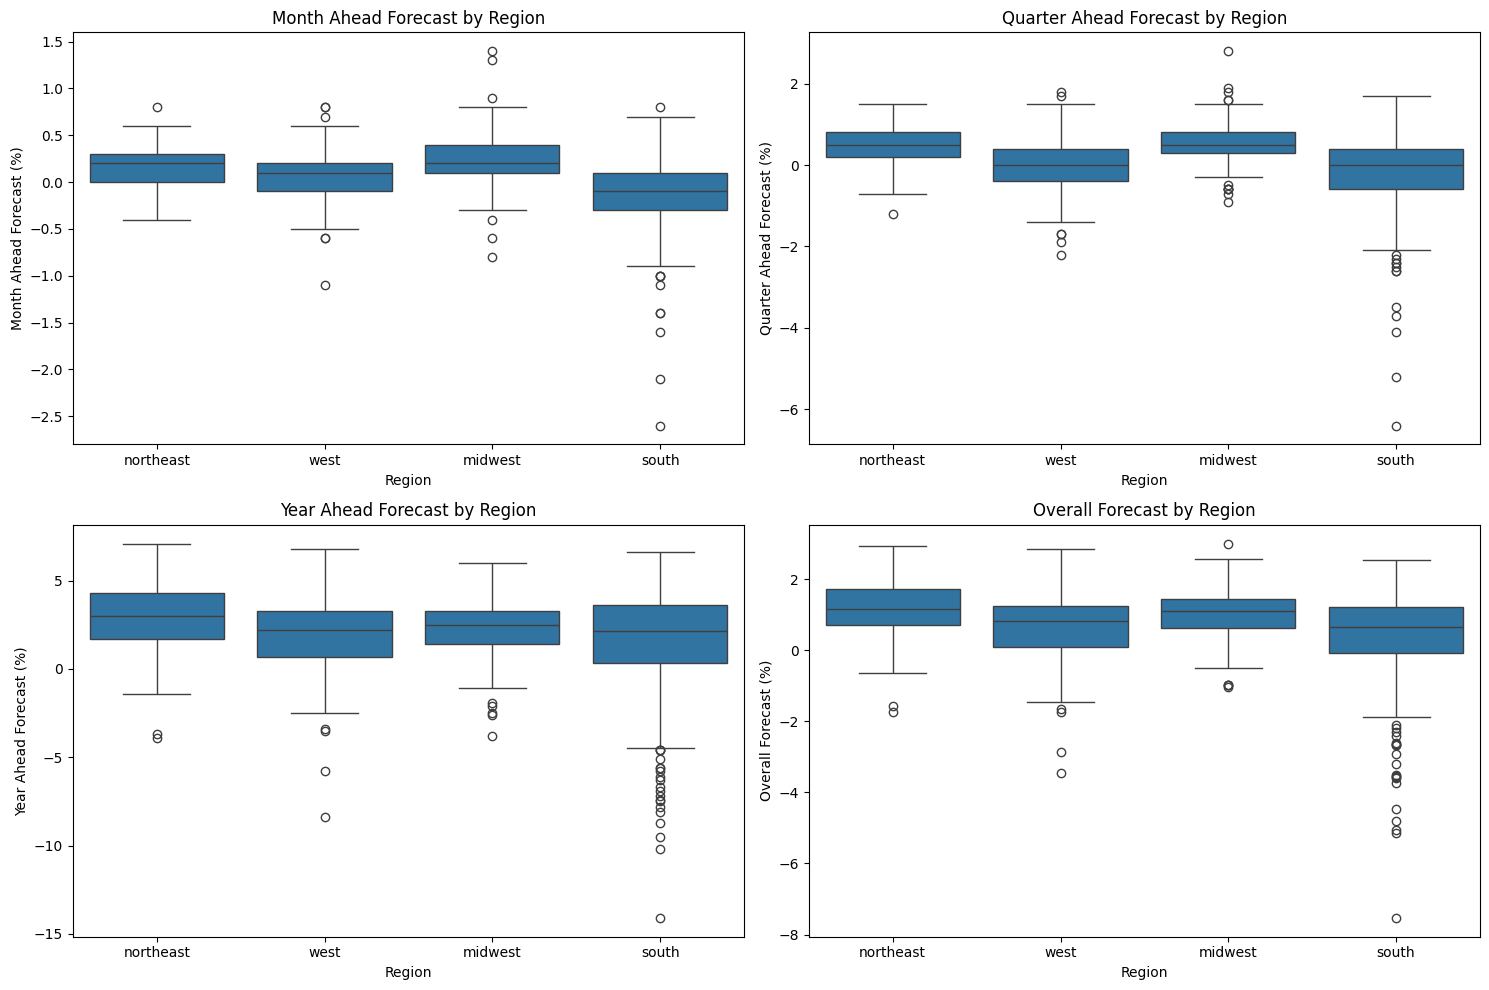

In [8]:
# Create box plots for each forecast type by region
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(x='region', y='month_ahead_forecast', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Month Ahead Forecast by Region')
axes[0, 0].set_xlabel('Region')
axes[0, 0].set_ylabel('Month Ahead Forecast (%)')

sns.boxplot(x='region', y='quarter_ahead_forecast', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Quarter Ahead Forecast by Region')
axes[0, 1].set_xlabel('Region')
axes[0, 1].set_ylabel('Quarter Ahead Forecast (%)')

sns.boxplot(x='region', y='year_ahead_forecast', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Year Ahead Forecast by Region')
axes[1, 0].set_xlabel('Region')
axes[1, 0].set_ylabel('Year Ahead Forecast (%)')

sns.boxplot(x='region', y='overall_forecast', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Overall Forecast by Region')
axes[1, 1].set_xlabel('Region')
axes[1, 1].set_ylabel('Overall Forecast (%)')

plt.tight_layout()
plt.show()

## Box Plot Conclusions
* Month Ahead
    * Variance is pretty similar across the board
    * Northeast and Midwest have the highest increases, with Northeast having a high median (stable price growth)
* Quarter Ahead
    * Similar results to Month Ahead IQR
* Year Ahead
    * Northeast has the highest growth and a high median
    * South has a great number of outliers
* Overall
    * Northeast has the highest growth and a moderate median

In [9]:
# Get the "northeast" region
northeast_df = df[df['region'] == 'northeast']

# A few examples of the data
display(northeast_df[northeast_df['state_name'] == 'VT']['month_ahead_forecast'].mean())
display(northeast_df[northeast_df['state_name'] == 'NJ']['month_ahead_forecast'].mean())

-0.22500000000000003

0.375

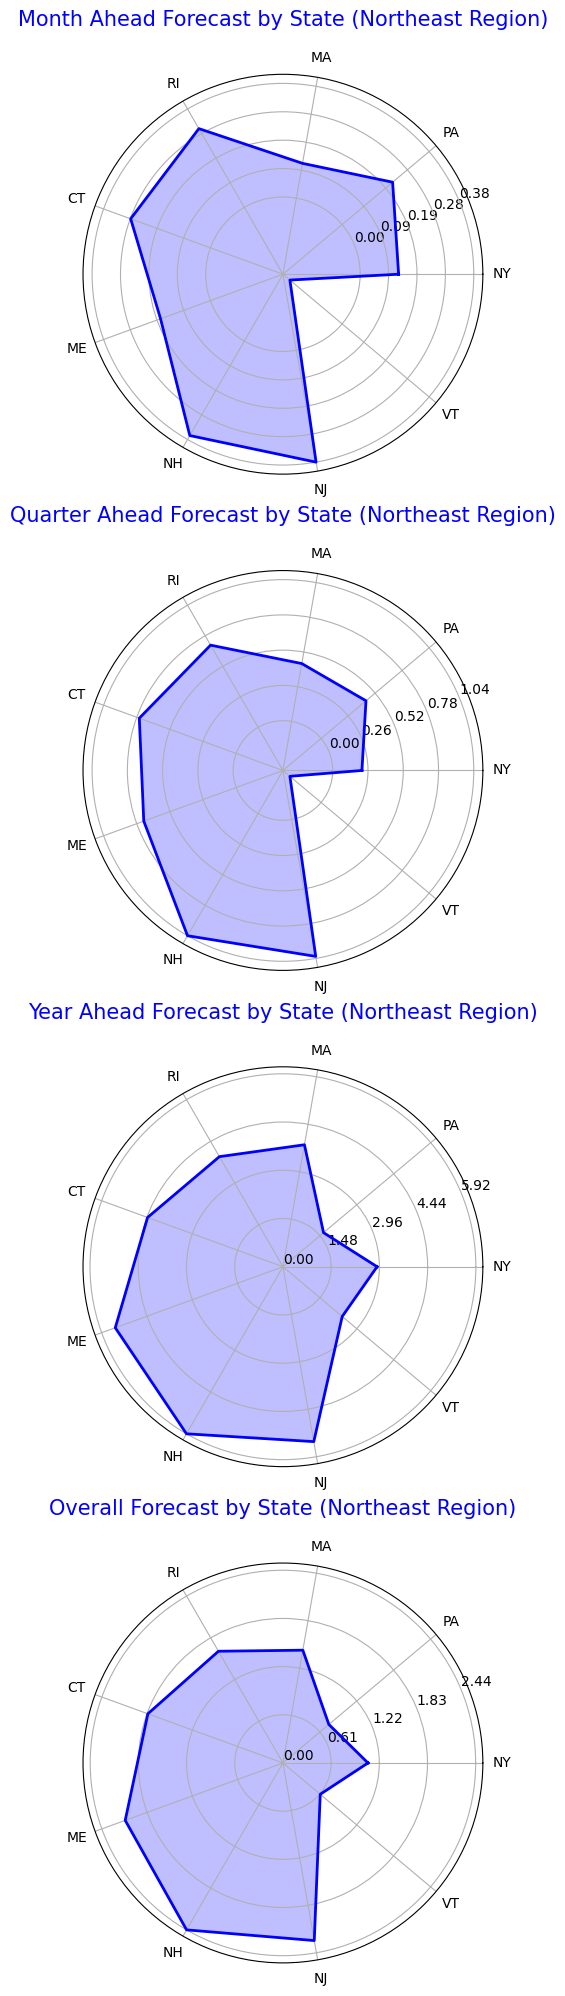

In [10]:
# Prepare data for radar chart
states = northeast_df['state_name'].unique()
num_vars = len(states)
# 2 * np.pi is a full circle (2 Radians)
# np.linspace creates a list of evenly spaced numbers over a specified interval
# endpoint=False means the stop value is not included in the list
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
# Add the first angle to the end to close the circle
angles += angles[:1] 

# Create Radar Chart
def create_radar_chart(ax, values, title):
    values += values[:1]
    ax.fill(angles, values, color='blue', alpha=0.25)
    ax.plot(angles, values, color='blue', linewidth=2)
    # Set y-ticks based on the maximum value in the data
    max_value = max(values)
    y_ticks = np.linspace(0, max_value, num=5)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f'{tick:.2f}' for tick in y_ticks])
 
    # Exclude the last angle because it's a duplicate of the first angle
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(states)
    ax.set_title(title, size=15, color='blue', y=1.1)

# Create radar plots
# polar=True makes the plot circular
fig, axs = plt.subplots(4, 1, figsize=(50, 20), subplot_kw=dict(polar=True))
axs = axs.flatten() # This helps with indexing

# Month Ahead Forecast
# This syntax is called a "List Comprehension" ([expression for item in iterable if condition])
month_values = [northeast_df[northeast_df['state_name'] == state]['month_ahead_forecast'].mean() for state in states]
create_radar_chart(axs[0], month_values, 'Month Ahead Forecast by State (Northeast Region)')

# Quarter Ahead Forecast
quarter_values = [northeast_df[northeast_df['state_name'] == state]['quarter_ahead_forecast'].mean() for state in states]
create_radar_chart(axs[1], quarter_values, 'Quarter Ahead Forecast by State (Northeast Region)')

# Year Ahead Forecast
year_values = [northeast_df[northeast_df['state_name'] == state]['year_ahead_forecast'].mean() for state in states]
create_radar_chart(axs[2], year_values, 'Year Ahead Forecast by State (Northeast Region)')

# Overall Forecast
overall_values = [northeast_df[northeast_df['state_name'] == state]['overall_forecast'].mean() for state in states]
create_radar_chart(axs[3], overall_values, 'Overall Forecast by State (Northeast Region)')

plt.tight_layout()
plt.show()

Q2) Are the sale prices and inventory listing going up or down overall in the US? - Brian

## Housing Prices

In [11]:
times_list = [
     '2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30',
    '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31',
    '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31',
    '2024-01-31', '2024-02-29', '2024-03-31', '2024-04-30',
    '2024-05-31', '2024-06-30', '2024-07-31', '2024-08-31',
    '2024-09-30', '2024-10-31'
]

#load price data from zillow
price_df = pd.read_csv('data/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')
#Create Pricing dataframe
US_price_df = price_df

In [12]:
#Create region dataframes based on region lists
ne_price_df = price_df[price_df["StateName"].isin(northeast)]
south_price_df = price_df[price_df["StateName"].isin(south)]
midwest_price_df = price_df[price_df["StateName"].isin(midwest)]
west_price_df = price_df[price_df["StateName"].isin(west)]

ne_price_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
1,394913,1,"New York, NY",msa,NY,216209.133034,217127.899860,218055.176122,219934.196642,221879.987460,...,636222.199812,640261.759998,645659.925232,651762.255593,656416.260742,659493.785408,662237.503625,665976.304121,669998.634470,673519.052950
7,394974,7,"Philadelphia, PA",msa,PA,120885.284445,121153.967178,121337.332448,121789.805109,122227.665999,...,349573.821124,351115.528213,353427.278973,356146.742879,358185.675031,359102.300166,359482.428176,360201.829714,361364.601769,362689.244874
10,394404,10,"Boston, MA",msa,MA,213384.568454,214244.746892,215185.855599,216922.736735,218788.262189,...,661723.243713,664372.499113,668945.226638,674875.680306,679914.600480,682604.079147,684180.695185,685840.933507,687878.713525,689653.370211
27,394982,27,"Pittsburgh, PA",msa,PA,84395.278983,84495.704018,84617.192715,84854.852406,85194.462096,...,208920.171245,209358.194633,210318.378483,211713.704761,213350.822286,214712.383606,215057.269425,214592.658510,213809.354545,213565.398741
38,395005,39,"Providence, RI",msa,RI,139108.758342,139617.091379,140208.127549,141366.761903,142259.615021,...,457973.444131,459500.828871,462218.490216,466214.412599,470361.339202,473468.422875,476195.674417,479068.253700,481953.890214,484565.777904


### Prices - Northeast

In [13]:
#Create a dict. and a series
ne_price_summary_dict = {}

for time in times_list: 
    ne_price_summary_dict[time] = ne_price_df[time].median()
    
ne_price_series = pd.Series(ne_price_summary_dict)
ne_price_series.index = pd.to_datetime(ne_price_series.index)

### Prices - South

In [14]:
#Create a dict. and a series
south_price_summary_dict = {}

for time in times_list: 
    south_price_summary_dict[time] = south_price_df[time].median()
    
south_price_series = pd.Series(south_price_summary_dict)
south_price_series.index = pd.to_datetime(south_price_series.index)

### Prices - Midwest

In [15]:
#Create a dict. and a series
midwest_price_summary_dict = {}

for time in times_list: 
    midwest_price_summary_dict[time] = midwest_price_df[time].median()
    
midwest_price_series = pd.Series(midwest_price_summary_dict)
midwest_price_series.index = pd.to_datetime(midwest_price_series.index)

### Prices - West

In [16]:
#Create a dict. and a series
west_price_summary_dict = {}

for time in times_list: 
    west_price_summary_dict[time] = west_price_df[time].median()
    
west_price_series = pd.Series(west_price_summary_dict)
west_price_series.index = pd.to_datetime(west_price_series.index)

Text(0, 0.5, 'Med. House Price')

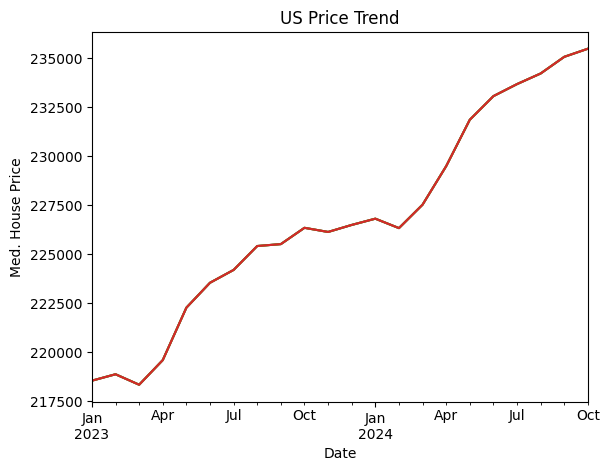

In [17]:
#Create a dict., series, and line chart
US_price_summary_dict = {}

for time in times_list: 
    US_price_summary_dict[time] = US_price_df[time].median()
    
US_price_series = pd.Series(US_price_summary_dict)
US_price_series.index = pd.to_datetime(US_price_series.index)
US_price_series.plot.line()
US_price_series.plot.line().set_title('US Price Trend')
US_price_series.plot.line().set_xlabel('Date')
US_price_series.plot.line().set_ylabel('Med. House Price')

In [18]:
print(US_price_series['2023-01-31'])
print(US_price_series['2024-10-31'])

218521.5709765556
235483.5096476744


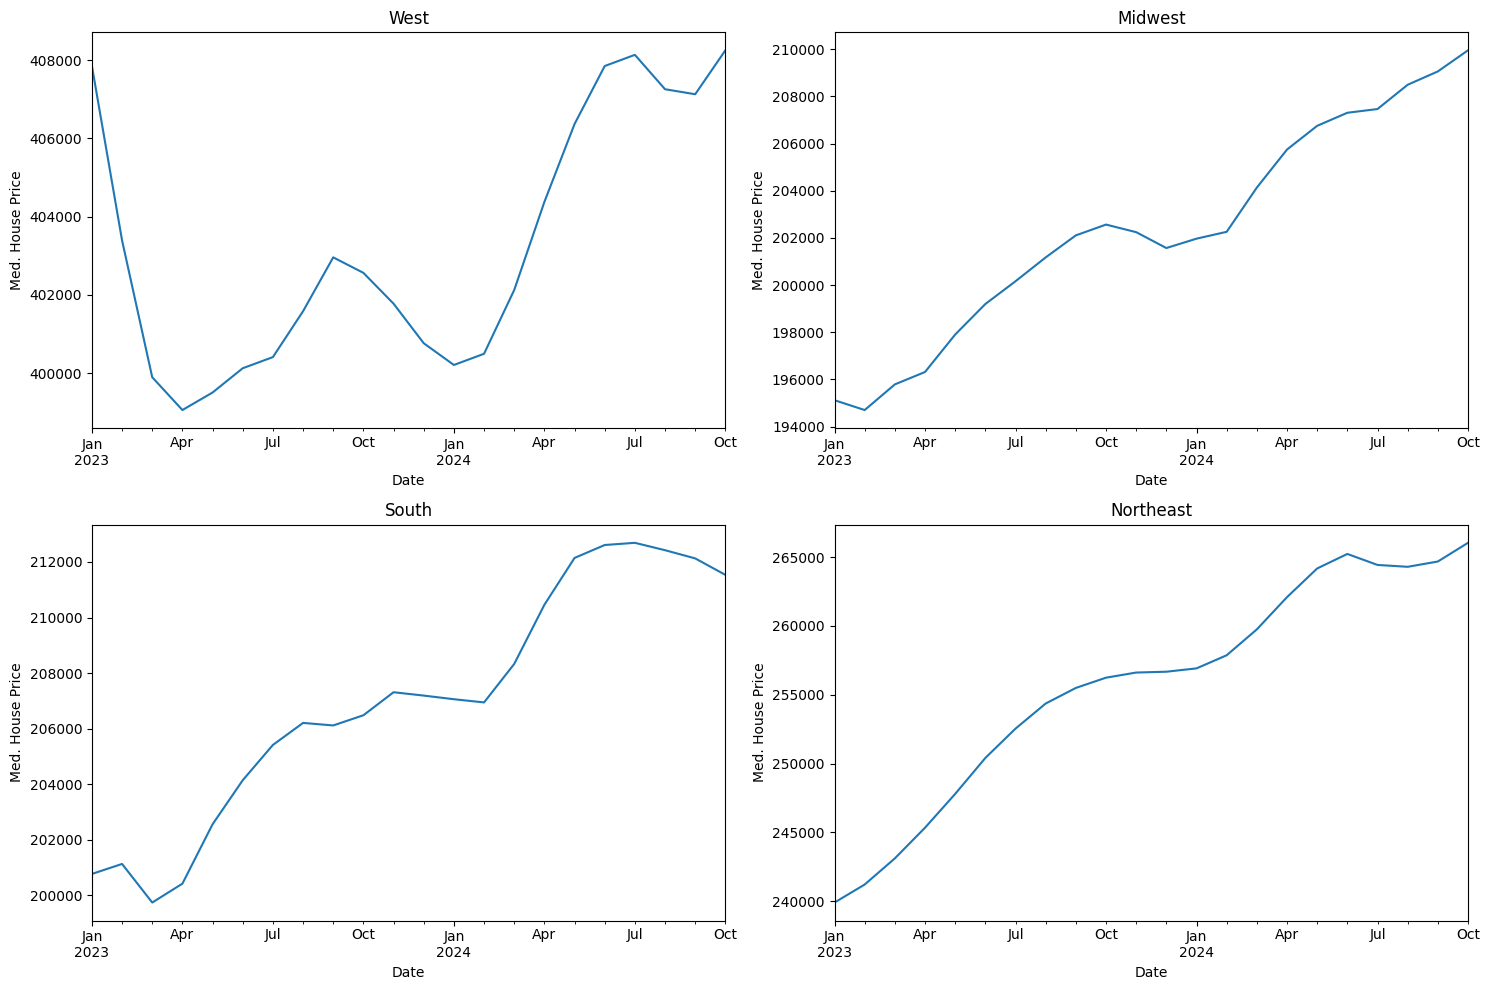

In [19]:
#Create 4 line charts for each region
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

west_price_series.plot.line(ax=axes[0,0])
axes[0, 0].set_title('West')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Med. House Price')

midwest_price_series.plot.line(ax=axes[0,1])
axes[0, 1].set_title('Midwest')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Med. House Price')

south_price_series.plot.line(ax=axes[1,0])
axes[1,0].set_title('South')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Med. House Price')

ne_price_series.plot.line(ax=axes[1,1])
axes[1, 1].set_title('Northeast')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Med. House Price')

plt.tight_layout()
plt.show()

## Housing Inventory

In [20]:
#Load inventory data from zillow
inventory_df = pd.read_csv("data/Metro_invt_fs_uc_sfrcondo_sm_month.csv")
#create US inventory DF
inventory_df
US_inventory_df = inventory_df

#Create region dataframes based on region lists
ne_inventory_df = inventory_df[inventory_df["StateName"].isin(northeast)]
south_inventory_df = inventory_df[inventory_df["StateName"].isin(south)]
midwest_inventory_df = inventory_df[inventory_df["StateName"].isin(midwest)]
west_inventory_df = inventory_df[inventory_df["StateName"].isin(west)]

### Inventory - Northeast

In [21]:
#Create a dict. and a series
ne_inventory_summary_dict = {}

for time in times_list: 
    ne_inventory_summary_dict[time] = ne_inventory_df[time].median()
    
ne_inventory_series = pd.Series(ne_inventory_summary_dict)
ne_inventory_series.index = pd.to_datetime(ne_inventory_series.index)

### Inventory - South

In [22]:
#Create a dict. and a series
south_inventory_summary_dict = {}

for time in times_list: 
    south_inventory_summary_dict[time] = south_inventory_df[time].median()
    
south_inventory_series = pd.Series(south_inventory_summary_dict)
south_inventory_series.index = pd.to_datetime(south_inventory_series.index)

### Inventory - Midwest

In [23]:
#Create a dict. and a series
midwest_inventory_summary_dict = {}

for time in times_list: 
    midwest_inventory_summary_dict[time] = midwest_inventory_df[time].median()
    
midwest_inventory_series = pd.Series(midwest_inventory_summary_dict)
midwest_inventory_series.index = pd.to_datetime(midwest_inventory_series.index)

### Inventory - West

Text(0, 0.5, 'Med. House inventory')

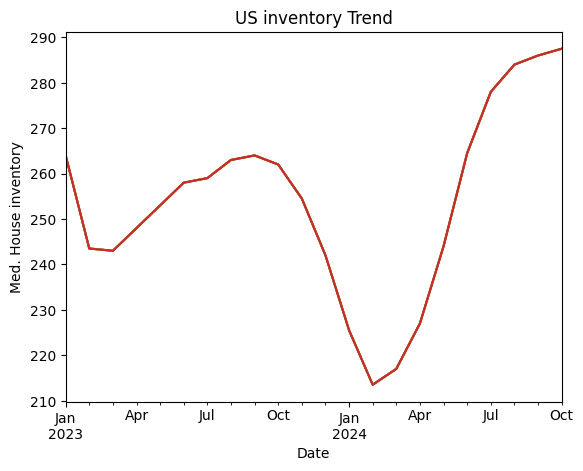

In [24]:
#Create a dict. and a series
west_inventory_summary_dict = {}

for time in times_list: 
    west_inventory_summary_dict[time] = west_inventory_df[time].median()
    
west_inventory_series = pd.Series(west_inventory_summary_dict)
west_inventory_series.index = pd.to_datetime(west_inventory_series.index)

#Create a dict., series, and line chart
US_inventory_summary_dict = {}

for time in times_list: 
    US_inventory_summary_dict[time] = US_inventory_df[time].median()
    
US_inventory_series = pd.Series(US_inventory_summary_dict)
US_inventory_series.index = pd.to_datetime(US_inventory_series.index)
US_inventory_series.plot.line()
US_inventory_series.plot.line().set_title('US inventory Trend')
US_inventory_series.plot.line().set_xlabel('Date')
US_inventory_series.plot.line().set_ylabel('Med. House inventory')

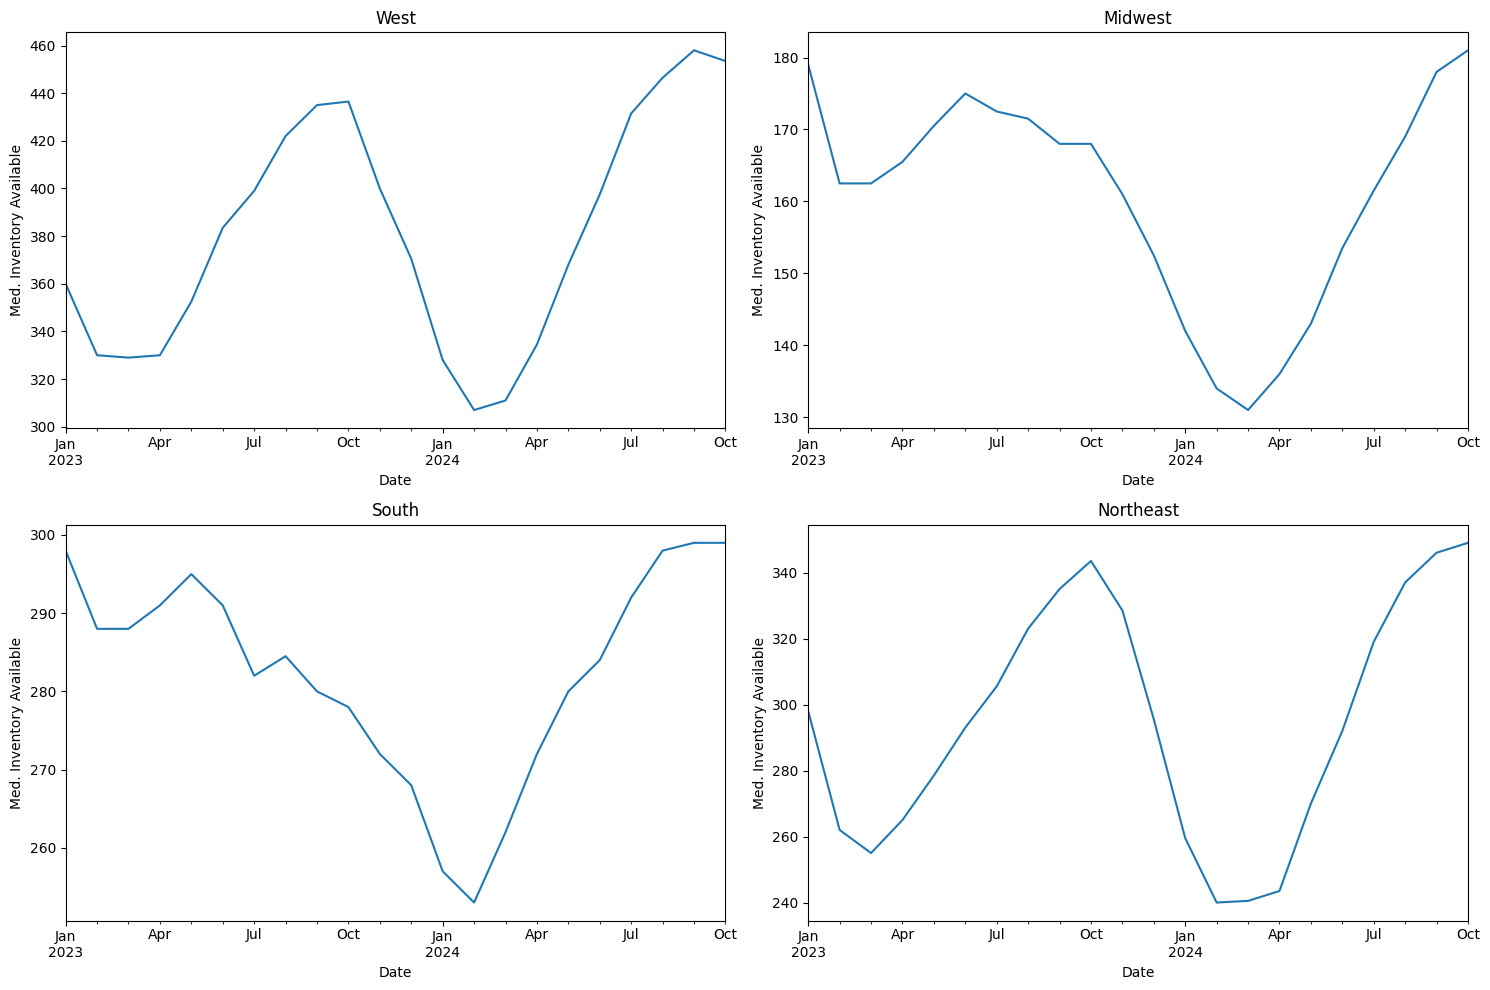

In [25]:
#Create 4 line charts for each region
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

west_inventory_series.plot.line(ax=axes[0,0])
axes[0, 0].set_title('West')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Med. Inventory Available')

midwest_inventory_series.plot.line(ax=axes[0,1])
axes[0, 1].set_title('Midwest')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Med. Inventory Available')

south_inventory_series.plot.line(ax=axes[1,0])
axes[1,0].set_title('South')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Med. Inventory Available')

ne_inventory_series.plot.line(ax=axes[1,1])
axes[1, 1].set_title('Northeast')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Med. Inventory Available')

plt.tight_layout()
plt.show()

### Q2) Conclusion - 
Sales prices come from ZHVI value for all data available from January of 20023 to October of 2024. In this time frame we see a stable increase in the median home value in all 4 regions and the overall US market. Median home values at the start of 2023 were $219k and by the end of Oct. 2024 they have reaced a value of $235k.

The inventory dataset provides the count of unique listings that were active at any time in a given month, across all housing types for the US. We can see a normal cyclical seasonal pattern, with higher median of inventory in the summer and lower inventory in the winter. We can also see the median amount of inventory in summer of 2024 was higher than at the same time in 2023. With intrest rates coming down year over year there has been more willingness to put an old house on the market to get a new one. 

With the trends we are seeing home median home values are contining to rise and while we will see inventory fall in the winter we excpect to see the inventory rise YoY.

Q3) Should I wait to invest or should I invest now and if so then where should I invest. (You could recommend more than one place)?

##### Loading Datasets

In [26]:
single_family_df = pd.read_csv("data/State_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month.csv")
all_homes_df = pd.read_csv("data/ZHV All homes Smoothed Forecast.csv")

##### Showing data

In [27]:
print("Single Family: ")
display(single_family_df.head(5))

print("All Homes: ")
display(all_homes_df.head(5))

Single Family: 


,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,9,0,California,state,NaN,189941.083557,190575.156948,191424.465351,193265.350054,195397.239796,...,767990.199085,767913.074896,769512.186358,773759.709911,778647.153064,781489.116381,783680.716030,785600.537660,787971.516726,789682.973337
1,54,1,Texas,state,NaN,111027.321208,111084.902957,111112.748505,111257.301986,111349.721806,...,299951.648526,300228.058078,301109.030655,301978.572060,302324.101841,302112.969026,301577.999813,301188.651460,300952.088105,300712.091402
2,14,2,Florida,state,NaN,113269.221141,113522.494633,113824.724865,114430.520208,115078.630576,...,412975.408432,413904.071012,414944.203899,415862.795269,416209.388878,415619.551410,414758.879266,413927.429781,413257.280087,412469.692485
3,43,3,New York,state,NaN,138979.501439,139444.664549,139897.446908,140878.333994,141899.073549,...,436255.509091,438648.840664,441631.820433,445308.012700,448638.592263,451330.079925,453622.474786,456378.737780,459093.248515,461615.264629
4,47,4,Pennsylvania,state,NaN,99325.159675,99534.907545,99734.576999,100139.362023,100552.787955,...,262071.016367,262933.274907,264263.880571,265948.793081,267456.133235,268371.119451,268732.316321,269001.236812,269407.285863,270173.074129


All Homes: 


,RegionID,SizeRank,RegionName,RegionType,StateName,BaseDate,2024-11-30,2025-01-31,2025-10-31
0,102001,0,United States,country,NaN,2024-10-31,0.2,0.6,2.9
1,394913,1,"New York, NY",msa,NY,2024-10-31,0.3,0.5,1.5
2,753899,2,"Los Angeles, CA",msa,CA,2024-10-31,0.2,0.4,2.3
3,394463,3,"Chicago, IL",msa,IL,2024-10-31,0.1,0.2,1.1
4,394514,4,"Dallas, TX",msa,TX,2024-10-31,-0.2,-0.7,1.2


In [28]:
print("Single Family: ")
display(single_family_df.tail(5))

print("All Homes: ")
display(all_homes_df.tail(5))

Single Family: 


,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
46,37,47,North Dakota,state,NaN,NaN,NaN,NaN,NaN,NaN,...,258046.945000,258196.872696,259649.354761,261542.187582,263077.869575,264304.543043,265336.741993,266250.209682,267047.587869,268007.903515
47,3,48,Alaska,state,NaN,135123.098557,135355.337187,135446.255981,135622.003071,135794.421166,...,368273.980915,369224.868438,370748.305928,371891.786888,372840.605453,373486.607926,373725.505066,373857.108571,374443.501187,375773.963522
48,12,49,District of Columbia,state,NaN,181591.414212,181990.032640,182670.910303,184198.672071,186029.977610,...,716912.553944,715995.390935,716772.957431,718160.637308,717777.184144,714288.229978,710489.606792,706989.450227,706641.608451,706313.617085
49,58,50,Vermont,state,NaN,114573.573888,114746.984203,115038.062219,115608.880655,116285.603386,...,389369.322394,388528.573156,389362.674568,391741.536805,393975.412098,395515.983557,395250.319468,394880.821828,394022.349713,393578.894823
50,62,51,Wyoming,state,NaN,NaN,NaN,NaN,NaN,NaN,...,341036.904110,341298.527667,342517.679679,344115.919408,345460.227042,346223.223400,346761.950907,348183.688728,350496.641190,353292.846225


All Homes: 


,RegionID,SizeRank,RegionName,RegionType,StateName,BaseDate,2024-11-30,2025-01-31,2025-10-31
890,753929,935,"Zapata, TX",msa,TX,2024-10-31,-0.8,-2.6,-7.2
891,394743,936,"Ketchikan, AK",msa,AK,2024-10-31,0.2,0.1,-0.9
892,753874,937,"Craig, CO",msa,CO,2024-10-31,0.4,1.0,4.4
893,395188,938,"Vernon, TX",msa,TX,2024-10-31,-1.4,-2.2,-4.3
894,394767,939,"Lamesa, TX",msa,TX,2024-10-31,-0.2,-0.7,-4.5


##### Drop Columns

In [29]:
single_family_df = single_family_df.drop(columns=["StateName"])

##### Data types

In [30]:
print("Single Family: ")
display(single_family_df.dtypes)

print("All Homes: ")
display(all_homes_df.dtypes)

Single Family: 


RegionID        int64
SizeRank        int64
RegionName     object
RegionType     object
2000-01-31    float64
               ...   
2024-06-30    float64
2024-07-31    float64
2024-08-31    float64
2024-09-30    float64
2024-10-31    float64
Length: 302, dtype: object

All Homes: 


RegionID        int64
SizeRank        int64
RegionName     object
RegionType     object
StateName      object
BaseDate       object
2024-11-30    float64
2025-01-31    float64
2025-10-31    float64
dtype: object

##### Data Shape

In [31]:
print("Single Family: ")
display(single_family_df.shape)

print("All Homes: ")
display(all_homes_df.shape)

Single Family: 


(51, 302)

All Homes: 


(895, 9)

##### Data Count

In [32]:
print("Single Family: ")
display(single_family_df.count())

print("All Homes: ")
display(all_homes_df.count())

Single Family: 


RegionID      51
SizeRank      51
RegionName    51
RegionType    51
2000-01-31    47
              ..
2024-06-30    51
2024-07-31    51
2024-08-31    51
2024-09-30    51
2024-10-31    51
Length: 302, dtype: int64

All Homes: 


RegionID      895
SizeRank      895
RegionName    895
RegionType    895
StateName     894
BaseDate      895
2024-11-30    895
2025-01-31    895
2025-10-31    895
dtype: int64

##### Drop Duplicates

In [33]:
single_family_df = single_family_df.drop_duplicates()
print("Single Family: ")
display(single_family_df.head(5))

all_homes_df = all_homes_df.drop_duplicates()
print("All Homes: ")
display(all_homes_df.head(5))

Single Family: 


,RegionID,SizeRank,RegionName,RegionType,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,9,0,California,state,189941.083557,190575.156948,191424.465351,193265.350054,195397.239796,197695.254730,...,767990.199085,767913.074896,769512.186358,773759.709911,778647.153064,781489.116381,783680.716030,785600.537660,787971.516726,789682.973337
1,54,1,Texas,state,111027.321208,111084.902957,111112.748505,111257.301986,111349.721806,111452.895994,...,299951.648526,300228.058078,301109.030655,301978.572060,302324.101841,302112.969026,301577.999813,301188.651460,300952.088105,300712.091402
2,14,2,Florida,state,113269.221141,113522.494633,113824.724865,114430.520208,115078.630576,115734.485011,...,412975.408432,413904.071012,414944.203899,415862.795269,416209.388878,415619.551410,414758.879266,413927.429781,413257.280087,412469.692485
3,43,3,New York,state,138979.501439,139444.664549,139897.446908,140878.333994,141899.073549,143006.421386,...,436255.509091,438648.840664,441631.820433,445308.012700,448638.592263,451330.079925,453622.474786,456378.737780,459093.248515,461615.264629
4,47,4,Pennsylvania,state,99325.159675,99534.907545,99734.576999,100139.362023,100552.787955,100975.065674,...,262071.016367,262933.274907,264263.880571,265948.793081,267456.133235,268371.119451,268732.316321,269001.236812,269407.285863,270173.074129


All Homes: 


,RegionID,SizeRank,RegionName,RegionType,StateName,BaseDate,2024-11-30,2025-01-31,2025-10-31
0,102001,0,United States,country,NaN,2024-10-31,0.2,0.6,2.9
1,394913,1,"New York, NY",msa,NY,2024-10-31,0.3,0.5,1.5
2,753899,2,"Los Angeles, CA",msa,CA,2024-10-31,0.2,0.4,2.3
3,394463,3,"Chicago, IL",msa,IL,2024-10-31,0.1,0.2,1.1
4,394514,4,"Dallas, TX",msa,TX,2024-10-31,-0.2,-0.7,1.2


In [34]:
print("Single family: ")
display(single_family_df.count())

print("All Homes: ")
display(all_homes_df.count())

Single family: 


RegionID      51
SizeRank      51
RegionName    51
RegionType    51
2000-01-31    47
              ..
2024-06-30    51
2024-07-31    51
2024-08-31    51
2024-09-30    51
2024-10-31    51
Length: 302, dtype: int64

All Homes: 


RegionID      895
SizeRank      895
RegionName    895
RegionType    895
StateName     894
BaseDate      895
2024-11-30    895
2025-01-31    895
2025-10-31    895
dtype: int64

In [35]:
# We have determined that there are no duplicates  so lets check for null values 
print("Single Family: ")
display(single_family_df.isnull().sum())

print("All Homes: ")
display(all_homes_df.isnull().sum())

Single Family: 


RegionID      0
SizeRank      0
RegionName    0
RegionType    0
2000-01-31    4
             ..
2024-06-30    0
2024-07-31    0
2024-08-31    0
2024-09-30    0
2024-10-31    0
Length: 302, dtype: int64

All Homes: 


RegionID      0
SizeRank      0
RegionName    0
RegionType    0
StateName     1
BaseDate      0
2024-11-30    0
2025-01-31    0
2025-10-31    0
dtype: int64

In [36]:
single_family_df = single_family_df.dropna()
print("Single Family: ")
display(single_family_df.isnull().sum())

all_homes_df = all_homes_df.dropna()
print("All Homes: ")
display(all_homes_df.isnull().sum())

Single Family: 


RegionID      0
SizeRank      0
RegionName    0
RegionType    0
2000-01-31    0
             ..
2024-06-30    0
2024-07-31    0
2024-08-31    0
2024-09-30    0
2024-10-31    0
Length: 302, dtype: int64

All Homes: 


RegionID      0
SizeRank      0
RegionName    0
RegionType    0
StateName     0
BaseDate      0
2024-11-30    0
2025-01-31    0
2025-10-31    0
dtype: int64

##### Showing Recent Growth Rates by states (2023-2024)

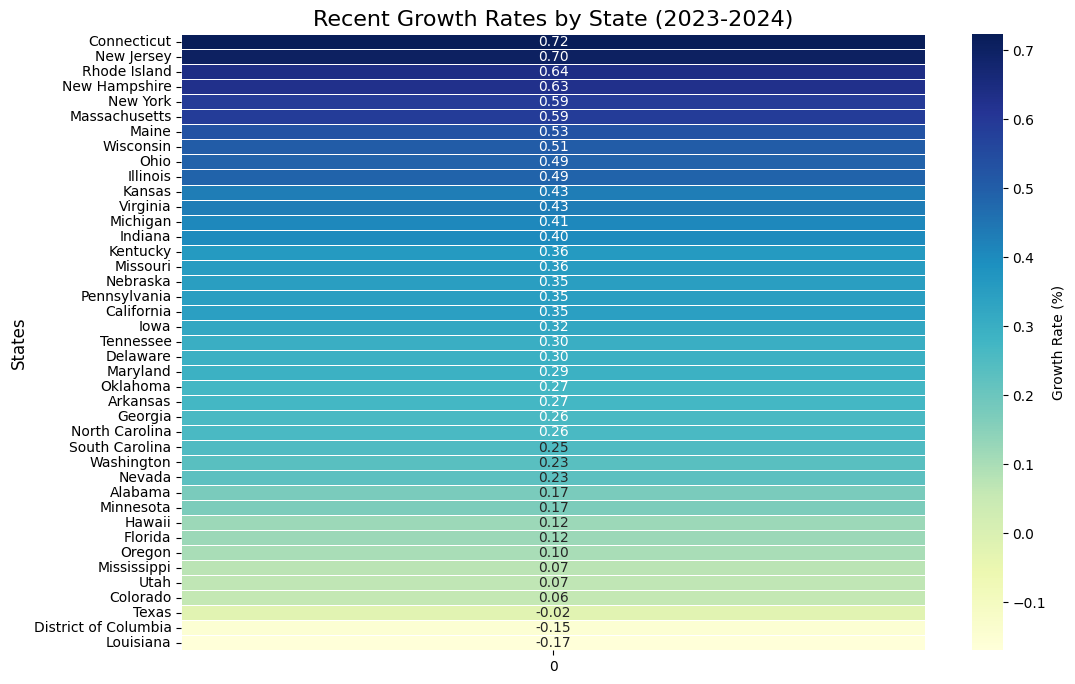

In [37]:

# Process the data to calculate recent growth rates
price_data = single_family_df.drop(['RegionID', 'SizeRank', 'RegionName', 'RegionType'], axis=1).T
price_data.columns = single_family_df['RegionName']
price_data.index = pd.to_datetime(price_data.index, errors='coerce')

# Calculate growth rates for 2023-2024
recent_growth = price_data.loc['2023-01-31':].pct_change().mean() * 100

# Sort states by growth rates
sorted_growth = recent_growth.sort_values(ascending=False)

# Create and display the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(sorted_growth.to_frame(), annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Growth Rate (%)'}, linewidths=0.5)
plt.title("Recent Growth Rates by State (2023-2024)", fontsize=16)
plt.xlabel("")
plt.ylabel("States", fontsize=12)
plt.xticks(rotation=0)
plt.show()


##### Home price growth forecast from November 2024 till October 2025

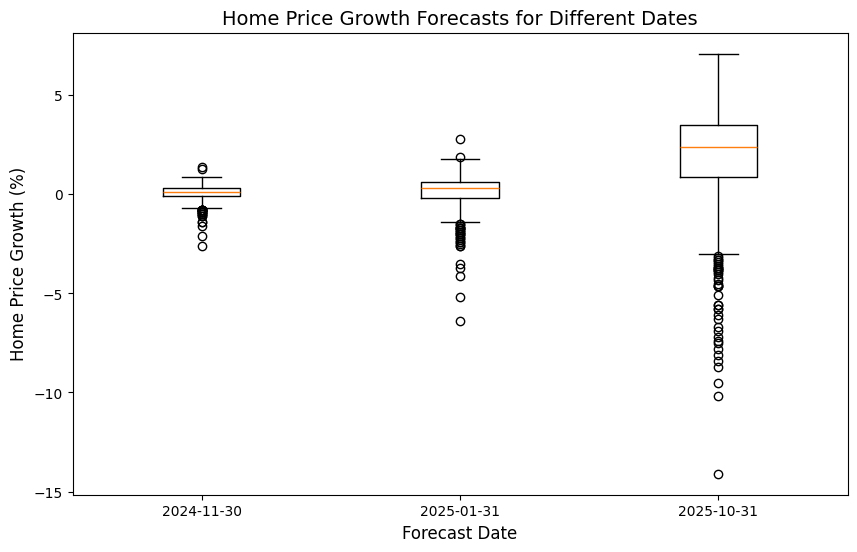

In [38]:
# Define the columns representing home price growth
growth_columns = ['2024-11-30', '2025-01-31', '2025-10-31']

# Set up the plot
plt.figure(figsize=(10, 6))

# Create box plots for each growth column
plt.boxplot([all_homes_df[column] for column in growth_columns], labels=growth_columns)

# Add a title and labels
plt.title('Home Price Growth Forecasts for Different Dates', fontsize=14)
plt.xlabel('Forecast Date', fontsize=12)
plt.ylabel('Home Price Growth (%)', fontsize=12)

# Show the boxplot
plt.show()


#### Calculating All Homes Average Growth (Nov 2024 onward)

In [39]:
# Load the dataset
#df = pd.read_csv("data/ZHV All homes Smoothed Forecast.csv")

# Define the columns representing home price growth
growth_columns = ['2024-11-30', '2025-01-31', '2025-10-31']

# Calculate average home price growth across the specified columns
all_homes_df['AverageGrowth'] = all_homes_df[growth_columns].mean(axis=1)

# Group by StateName and calculate the mean growth per state
state_growth = all_homes_df.groupby('StateName')['AverageGrowth'].mean().dropna()

# Sort the states by average growth and get the top 10
top_10_states = state_growth.sort_values(ascending=False).head(10)

# Print the top 10 states
display(top_10_states)


StateName
NH    2.440000
NJ    2.283333
ME    2.125000
CT    1.820000
MT    1.666667
RI    1.633333
IN    1.561111
DE    1.500000
ID    1.484615
WI    1.456522
Name: AverageGrowth, dtype: float64

#### All Homes Average Growth for Top 10 States

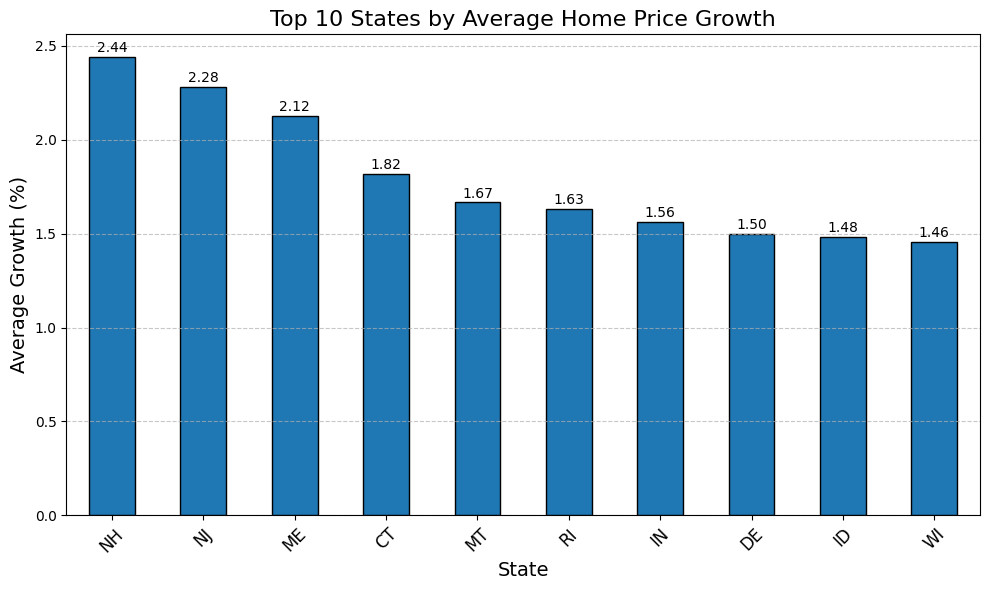

In [40]:
# Create the vertical bar graph
plt.figure(figsize=(10, 6))
bars = top_10_states.plot(kind='bar', edgecolor='black')

# Add numeric labels on top of each bar
for bar in bars.patches:
    height = bar.get_height()  # Get the height of each bar
    plt.text(
        x=bar.get_x() + bar.get_width() / 2,  # X position
        y=height + 0.01,                      # Y position (slightly above the bar)
        s=f'{height:.2f}',                    # Label text
        ha='center',                          # Horizontal alignment
        va='bottom',                          # Vertical alignment
        fontsize=10                           # Font size for labels
    )

# Add titles and labels
plt.title('Top 10 States by Average Home Price Growth', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Average Growth (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


### Assumption
The Election were the cause of the spike of November 2024 
Had no outliers

#### All Homes Growth Forecast

In [41]:
top_10_states.index.tolist()

['NH', 'NJ', 'ME', 'CT', 'MT', 'RI', 'IN', 'DE', 'ID', 'WI']

/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters foun

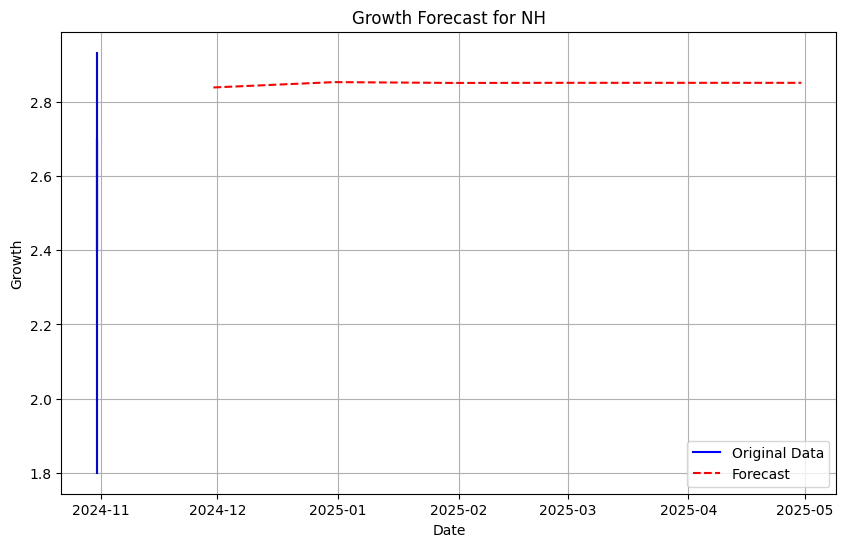

/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters f

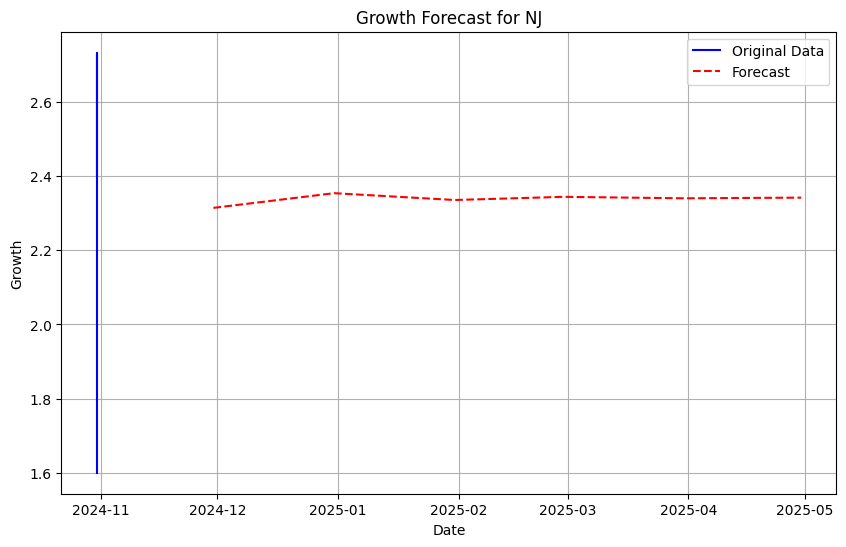

/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters f

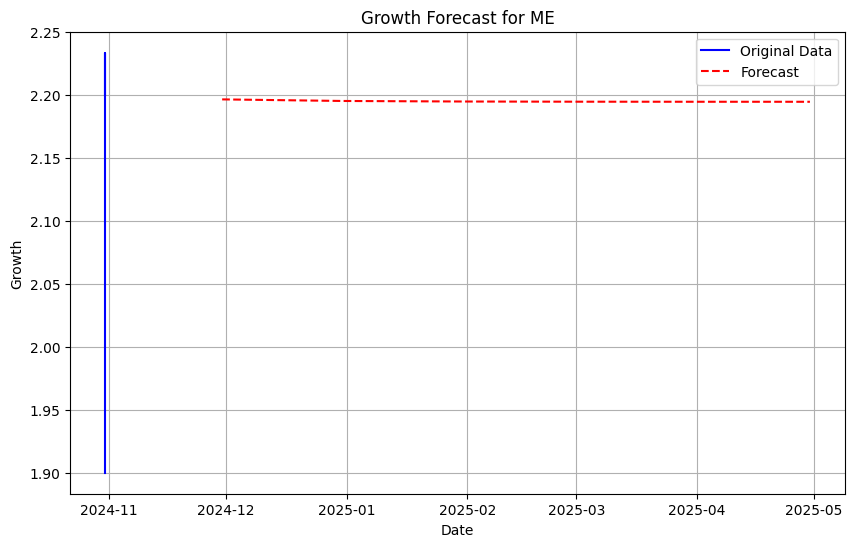

/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will 

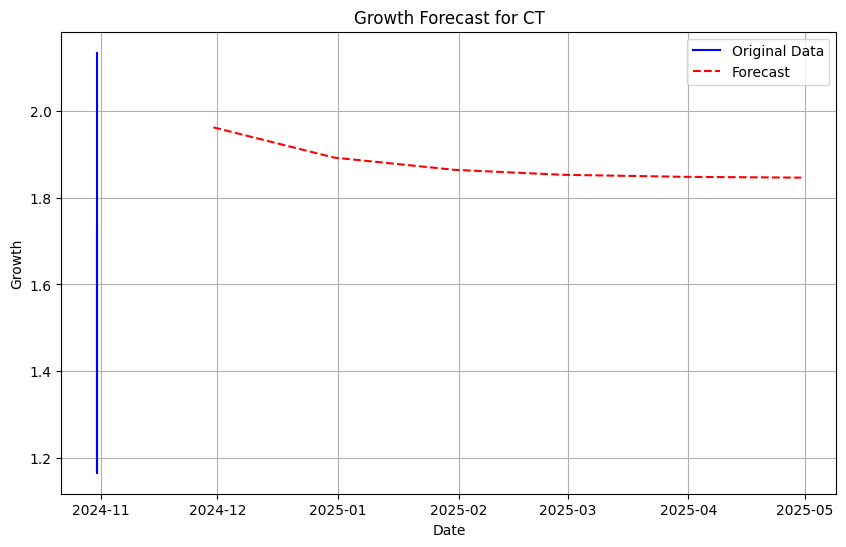

/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will 

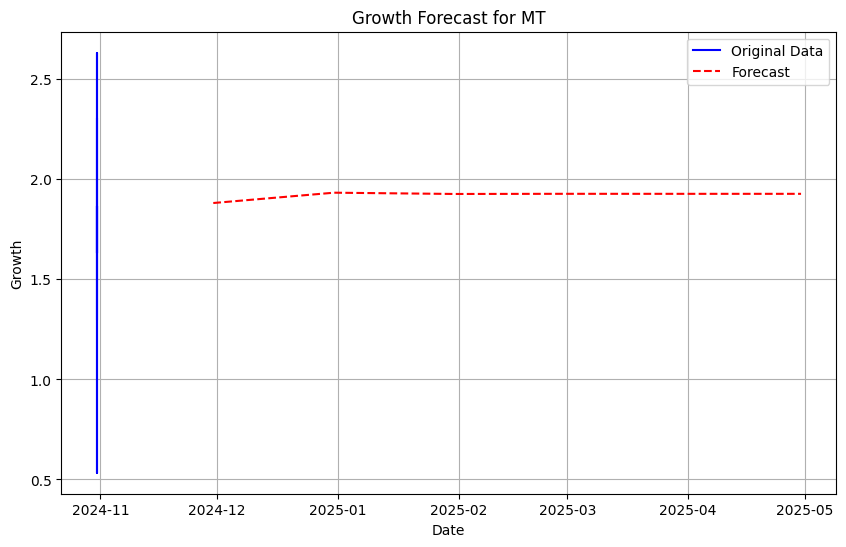

Not enough data to fit ARIMA model for RI


/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will 

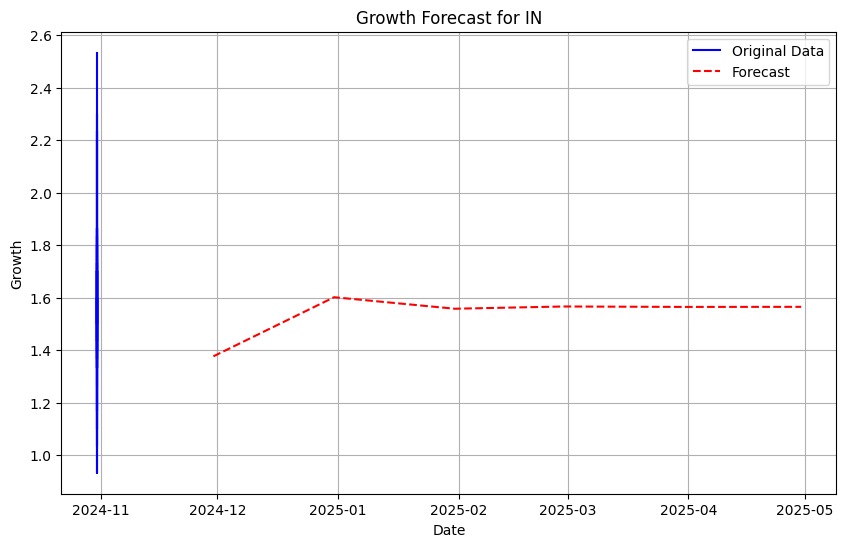

/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated 

ARIMA model failed for DE: too many indices for array: array is 0-dimensional, but 1 were indexed


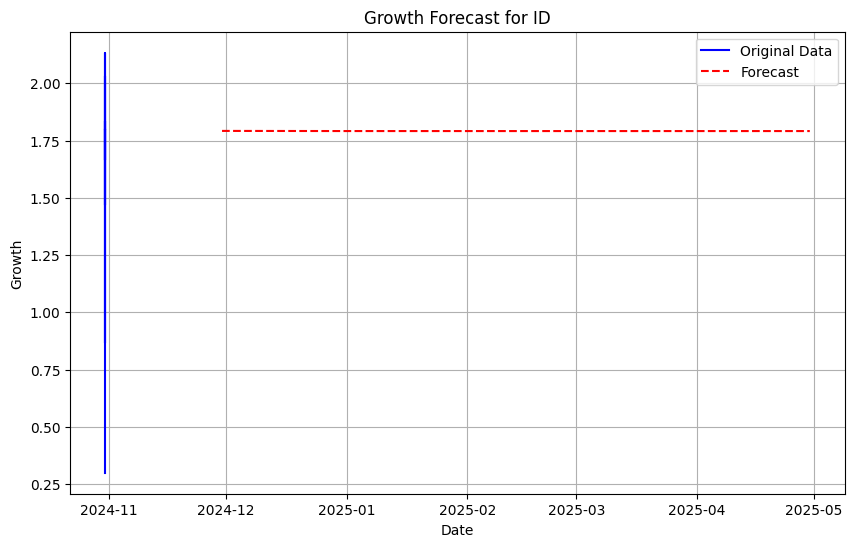

/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tony.challeen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will 

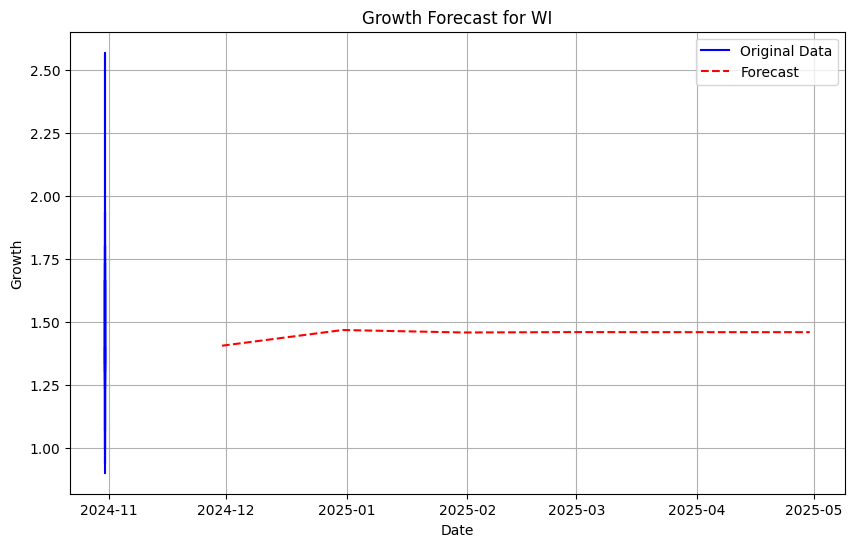

In [43]:
all_homes_data = all_homes_df.copy()

# Ensure 'BaseDate' is in datetime format and sort the data
if 'BaseDate' in all_homes_data.columns:
    
    # Step 1: Convert BaseDate to datetime
    all_homes_data['BaseDate'] = pd.to_datetime(all_homes_data['BaseDate'], errors='coerce')

    # Step 2: Set BaseDate as index
    all_homes_data.set_index('BaseDate', inplace=True)

    # Step 3: Remove duplicate indices
    #all_homes_data = all_homes_data[~all_homes_data.index.duplicated()]

    # Step 4: Define frequency
    #all_homes_data = all_homes_data.asfreq('M')

    # Optional: Fill missing data
    #all_homes_data = all_homes_data.fillna(method='ffill')


# Loop through each top 10 state to forecast growth
for state in top_10_states.index:
    #state_data = top_10_states[top_10_states['StateName'] == state]
    state_data = all_homes_data[all_homes_data["StateName"] == state]

    # Set the 'AverageGrowth' column as the time series and drop missing values
    state_series = state_data['AverageGrowth'].dropna()

    if state_series.empty:
        print(f"No data for {state}")
        continue

    if len(state_series) < 2:
        print(f"Not enough data to fit ARIMA model for {state}")
        continue

    # Fit ARIMA model
    try:
        model = ARIMA(state_series, order=(1, 1, 1))
        model_fit = model.fit()
    except Exception as e:
        print(f"ARIMA model failed for {state}: {e}")
        continue

    # Forecast the next 6 months
    forecast = model_fit.forecast(steps=6)

    # Generate forecast index for the next 6 months
    try:
        forecast_index = pd.date_range(start=state_series.index[-1], periods=7, freq='M')[1:]
    except Exception as e:
        print(f"Error generating forecast index for {state}: {e}")
        continue

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(state_series.index, state_series, label='Original Data', color='blue')
    plt.plot(forecast_index, forecast, label='Forecast', color='red', linestyle='--')
    plt.title(f'Growth Forecast for {state}')
    plt.xlabel('Date')
    plt.ylabel('Growth')
    plt.legend()
    plt.grid(True)
    plt.show()

Q3 : Should I wait to invest or should I invest now and if so then where should I invest. (You could recommend more than one place)

Recent growth rate  by state for single family homes  from 2023- 2024 show that the top 10 states that Connecticut , New Jersey , Rhode Island , New Hampshire , New York , Massachusets , Maine , Wisconsin , Ohio and Illinois respectively were the top perfomers. It is noteworthy that the top 7 states are all in the North Eastern Region.

When it came to all homes the home price growth forecast shows that there is positive increase from Novermber 2024 to January 2025  which then exponentially increase in October 2025.

The top 10 states by Average Home price growth showed how competitive the NorthEastern Region is .New Hampshire recording the highest growth at 2.44%, followed by New Jersey at 2.28 %, Maine being third with 2.12 , Connecticut placed fourth with 1.82 and Montana , the only  state in top 5 outside of the North Eastern region .

The state by state growth forecast for the states in top 10 (growth ) using ARIMA showed a 6 month growth forecast of the home value growth for all the states . The best places to Invest in the NorthEastern region are Newhampshire , Maine and New Jersey

Should I Invest Now or Wait ? If so where?

Invest now because the market forecast is showing positive growth. 
Invest in the North Eastern Region particulary Maine, New Jersey and New Hampshire 


## Q4) How long some of the real-estate stays on the market before they rent or sell? - Tony

In [44]:
# Load Zillow data - "Days on Market and Price Cuts" and inspect data

## Data Sources ##
# Mean Days to Pending (Smooth, All Homes, Monthly)
# Mean Days to Close (Smooth, All Homes, Monthly)

df_duration_pending = pd.read_csv('data/Metro_mean_doz_pending_uc_sfrcondo_sm_month.csv')
df_duration_close = pd.read_csv('data/Metro_mean_days_to_close_uc_sfrcondo_sm_month.csv')

df_duration_pending.columns.name = "Pending Data"
df_duration_close.columns.name = "Closing Data"

# Common function we could use to cut down on the amount of code in our notebook
def dataframe_check(dataframe_name):
    display(dataframe_name.head(5))
    display(dataframe_name.tail(5))
    display(dataframe_name.count())

dataframe_check(df_duration_pending)
dataframe_check(df_duration_close)

Pending Data,RegionID,SizeRank,RegionName,RegionType,StateName,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,102001,0,United States,country,NaN,51.0,48.0,45.0,43.0,44.0,...,49.0,52.0,49.0,43.0,39.0,37.0,38.0,41.0,44.0,46.0
1,394913,1,"New York, NY",msa,NY,68.0,65.0,63.0,64.0,66.0,...,68.0,71.0,67.0,58.0,51.0,49.0,49.0,52.0,55.0,58.0
2,753899,2,"Los Angeles, CA",msa,CA,35.0,32.0,31.0,32.0,33.0,...,40.0,41.0,37.0,33.0,30.0,29.0,30.0,33.0,36.0,38.0
3,394463,3,"Chicago, IL",msa,IL,51.0,44.0,40.0,39.0,40.0,...,42.0,43.0,38.0,31.0,26.0,24.0,24.0,25.0,28.0,31.0
4,394514,4,"Dallas, TX",msa,TX,46.0,42.0,38.0,37.0,38.0,...,51.0,52.0,49.0,43.0,39.0,38.0,40.0,45.0,50.0,54.0


Pending Data,RegionID,SizeRank,RegionName,RegionType,StateName,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
721,395241,881,"Yankton, SD",msa,SD,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0
722,394403,899,"Borger, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.0
723,753925,910,"Vineyard Haven, MA",msa,MA,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.0
724,786263,913,"Ruidoso, NM",msa,NM,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0,86.0,89.0
725,394805,916,"Los Alamos, NM",msa,NM,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,18.0,17.0,19.0,19.0,15.0,13.0,21.0


Pending Data
RegionID      726
SizeRank      726
RegionName    726
RegionType    726
StateName     725
             ... 
2024-06-30    678
2024-07-31    681
2024-08-31    688
2024-09-30    693
2024-10-31    726
Length: 85, dtype: int64

Closing Data,RegionID,SizeRank,RegionName,RegionType,StateName,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
0,102001,0,United States,country,NaN,35.0,34.0,34.0,35.0,36.0,...,33.0,34.0,34.0,33.0,32.0,33.0,34.0,34.0,34.0,34.0
1,394913,1,"New York, NY",msa,NY,57.0,53.0,50.0,51.0,53.0,...,53.0,54.0,55.0,54.0,52.0,51.0,53.0,54.0,55.0,55.0
2,753899,2,"Los Angeles, CA",msa,CA,34.0,32.0,33.0,33.0,34.0,...,30.0,31.0,30.0,30.0,29.0,29.0,29.0,29.0,29.0,30.0
3,394463,3,"Chicago, IL",msa,IL,43.0,42.0,42.0,44.0,45.0,...,37.0,38.0,37.0,37.0,36.0,37.0,38.0,38.0,38.0,37.0
4,394514,4,"Dallas, TX",msa,TX,21.0,21.0,21.0,22.0,22.0,...,28.0,28.0,28.0,28.0,28.0,28.0,29.0,29.0,29.0,28.0


Closing Data,RegionID,SizeRank,RegionName,RegionType,StateName,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
618,394869,869,"Moberly, MO",msa,MO,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,32.0,34.0,34.0,35.0,34.0,38.0
619,395004,872,"Prineville, OR",msa,OR,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,34.0,37.0,39.0,40.0,38.0,38.0,36.0
620,394418,880,"Brookings, OR",msa,OR,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,35.0,33.0,35.0,33.0
621,394805,916,"Los Alamos, NM",msa,NM,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,32.0,33.0,33.0,32.0,33.0
622,395112,922,"Spirit Lake, IA",msa,IA,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,30.0,31.0,32.0,35.0,32.0,31.0,31.0


Closing Data
RegionID      623
SizeRank      623
RegionName    623
RegionType    623
StateName     622
             ... 
2024-05-31    600
2024-06-30    606
2024-07-31    610
2024-08-31    619
2024-09-30    623
Length: 84, dtype: int64

## Days to Pending

How long it takes homes in a region to change to pending status on Zillow.com after first being shown as for sale. The reported figure indicates the number of days (mean or median) that it took for homes that went pending during the week being reported, to go pending. This differs from the old “Days on Zillow” metric in that it excludes the in-contract period before a home sells.

In [45]:
#Rename column headers to our standards used above
df_duration_pending = df_duration_pending.rename(columns={"RegionID": "region_id", 
                        "SizeRank": "size_rank", 
                        "RegionName": "metro_area",
                        "RegionType": "region_type",
                        "StateName": "state_name"})

df_duration_close = df_duration_close.rename(columns={"RegionID": "region_id", 
                        "SizeRank": "size_rank", 
                        "RegionName": "metro_area",
                        "RegionType": "region_type",
                        "StateName": "state_name"})

# drop unnecessary columns
df_duration_pending = df_duration_pending.drop(["region_id","size_rank","region_type"], axis=1)
df_duration_close = df_duration_close.drop(["region_id","size_rank","region_type"], axis=1)

# drop any column over 2 years old
df_duration_pending = df_duration_pending.drop(df_duration_pending.columns[2:-24], axis=1)
df_duration_close = df_duration_close.drop(df_duration_close.columns[2:-24], axis=1)

# Add the region column
df_duration_pending.insert(2, "region", df["state_name"].map(region_map))
display(df_duration_pending.head(5))

df_duration_close.insert(2, "region", df["state_name"].map(region_map))
display(df_duration_close.head(5))

Pending Data,metro_area,state_name,region,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,United States,NaN,NaN,37.0,42.0,49.0,51.0,49.0,43.0,37.0,...,49.0,52.0,49.0,43.0,39.0,37.0,38.0,41.0,44.0,46.0
1,"New York, NY",NY,northeast,60.0,65.0,72.0,76.0,73.0,65.0,58.0,...,68.0,71.0,67.0,58.0,51.0,49.0,49.0,52.0,55.0,58.0
2,"Los Angeles, CA",CA,west,39.0,44.0,50.0,52.0,49.0,42.0,35.0,...,40.0,41.0,37.0,33.0,30.0,29.0,30.0,33.0,36.0,38.0
3,"Chicago, IL",IL,midwest,37.0,43.0,50.0,52.0,46.0,37.0,30.0,...,42.0,43.0,38.0,31.0,26.0,24.0,24.0,25.0,28.0,31.0
4,"Dallas, TX",TX,south,33.0,40.0,46.0,49.0,45.0,37.0,30.0,...,51.0,52.0,49.0,43.0,39.0,38.0,40.0,45.0,50.0,54.0


Closing Data,metro_area,state_name,region,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
0,United States,NaN,NaN,35.0,35.0,34.0,35.0,34.0,34.0,33.0,...,33.0,34.0,34.0,33.0,32.0,33.0,34.0,34.0,34.0,34.0
1,"New York, NY",NY,northeast,53.0,52.0,53.0,55.0,55.0,55.0,53.0,...,53.0,54.0,55.0,54.0,52.0,51.0,53.0,54.0,55.0,55.0
2,"Los Angeles, CA",CA,west,30.0,30.0,30.0,31.0,31.0,30.0,29.0,...,30.0,31.0,30.0,30.0,29.0,29.0,29.0,29.0,29.0,30.0
3,"Chicago, IL",IL,midwest,38.0,38.0,37.0,38.0,37.0,37.0,37.0,...,37.0,38.0,37.0,37.0,36.0,37.0,38.0,38.0,38.0,37.0
4,"Dallas, TX",TX,south,28.0,29.0,28.0,29.0,29.0,29.0,28.0,...,28.0,28.0,28.0,28.0,28.0,28.0,29.0,29.0,29.0,28.0


In [46]:
# Common function we could use to cut down on the amount of code in our notebook
## This function drops duplicates missing/null values and provides statistics prior to and after changes
def check_dup_null(dataframe_name):
    
    # List number of rows
    print("Before Dropping - number of rows,columns: ", dataframe_name.shape)
    
    # Drop the duplicates - (no duplicates found)
    dataframe_name = dataframe_name.drop_duplicates()
    
    # Drop Missing/Null Values (no null values found)
    print("Sum of null values:\n", dataframe_name.isnull().sum())
    dataframe_name = dataframe_name.dropna()
    
    print("After Dropping - number of rows,columns: ", dataframe_name.shape)
    
    display(dataframe_name.count())
    
    display(dataframe_name.head(5))
    display(dataframe_name.tail(5))
    
    return dataframe_name


In [47]:
# Display drop results for Mean Days to Pending Data
df_duration_pending = check_dup_null(df_duration_pending)

Before Dropping - number of rows,columns:  (726, 27)
Sum of null values:
 Pending Data
metro_area      0
state_name      1
region          1
2022-11-30    190
2022-12-31    186
2023-01-31    170
2023-02-28    165
2023-03-31    160
2023-04-30    159
2023-05-31    158
2023-06-30    158
2023-07-31    157
2023-08-31    156
2023-09-30    155
2023-10-31    155
2023-11-30    154
2023-12-31    146
2024-01-31    106
2024-02-29     83
2024-03-31     64
2024-04-30     57
2024-05-31     51
2024-06-30     48
2024-07-31     45
2024-08-31     38
2024-09-30     33
2024-10-31      0
dtype: int64
After Dropping - number of rows,columns:  (535, 27)


Pending Data
metro_area    535
state_name    535
region        535
2022-11-30    535
2022-12-31    535
2023-01-31    535
2023-02-28    535
2023-03-31    535
2023-04-30    535
2023-05-31    535
2023-06-30    535
2023-07-31    535
2023-08-31    535
2023-09-30    535
2023-10-31    535
2023-11-30    535
2023-12-31    535
2024-01-31    535
2024-02-29    535
2024-03-31    535
2024-04-30    535
2024-05-31    535
2024-06-30    535
2024-07-31    535
2024-08-31    535
2024-09-30    535
2024-10-31    535
dtype: int64

Pending Data,metro_area,state_name,region,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
1,"New York, NY",NY,northeast,60.0,65.0,72.0,76.0,73.0,65.0,58.0,...,68.0,71.0,67.0,58.0,51.0,49.0,49.0,52.0,55.0,58.0
2,"Los Angeles, CA",CA,west,39.0,44.0,50.0,52.0,49.0,42.0,35.0,...,40.0,41.0,37.0,33.0,30.0,29.0,30.0,33.0,36.0,38.0
3,"Chicago, IL",IL,midwest,37.0,43.0,50.0,52.0,46.0,37.0,30.0,...,42.0,43.0,38.0,31.0,26.0,24.0,24.0,25.0,28.0,31.0
4,"Dallas, TX",TX,south,33.0,40.0,46.0,49.0,45.0,37.0,30.0,...,51.0,52.0,49.0,43.0,39.0,38.0,40.0,45.0,50.0,54.0
5,"Houston, TX",TX,south,41.0,47.0,54.0,57.0,55.0,49.0,43.0,...,58.0,63.0,60.0,54.0,49.0,47.0,49.0,53.0,57.0,60.0


Pending Data,metro_area,state_name,region,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
669,"Lebanon, MO",MO,south,43.0,51.0,58.0,52.0,49.0,44.0,50.0,...,57.0,62.0,68.0,64.0,63.0,55.0,55.0,49.0,47.0,41.0
670,"Vernal, UT",UT,south,60.0,54.0,57.0,60.0,65.0,55.0,49.0,...,71.0,69.0,69.0,71.0,69.0,64.0,60.0,58.0,72.0,63.0
691,"Berlin, NH",NH,northeast,48.0,44.0,42.0,50.0,67.0,67.0,52.0,...,60.0,67.0,72.0,69.0,62.0,53.0,47.0,57.0,59.0,67.0
693,"Breckenridge, CO",CO,midwest,54.0,65.0,70.0,77.0,62.0,53.0,37.0,...,78.0,78.0,73.0,56.0,40.0,34.0,40.0,52.0,65.0,82.0
703,"Mineral Wells, TX",TX,midwest,52.0,64.0,82.0,85.0,85.0,81.0,77.0,...,97.0,115.0,113.0,118.0,110.0,107.0,106.0,102.0,99.0,105.0


In [48]:
# Display drop results for Mean Days to Closing Data
df_duration_close = check_dup_null(df_duration_close)

Before Dropping - number of rows,columns:  (623, 27)
Sum of null values:
 Closing Data
metro_area      0
state_name      1
region          1
2022-10-31    149
2022-11-30    148
2022-12-31    147
2023-01-31    145
2023-02-28    137
2023-03-31    133
2023-04-30    131
2023-05-31    128
2023-06-30    127
2023-07-31    127
2023-08-31    128
2023-09-30    124
2023-10-31    124
2023-11-30    122
2023-12-31    118
2024-01-31    114
2024-02-29     89
2024-03-31     47
2024-04-30     32
2024-05-31     23
2024-06-30     17
2024-07-31     13
2024-08-31      4
2024-09-30      0
dtype: int64
After Dropping - number of rows,columns:  (467, 27)


Closing Data
metro_area    467
state_name    467
region        467
2022-10-31    467
2022-11-30    467
2022-12-31    467
2023-01-31    467
2023-02-28    467
2023-03-31    467
2023-04-30    467
2023-05-31    467
2023-06-30    467
2023-07-31    467
2023-08-31    467
2023-09-30    467
2023-10-31    467
2023-11-30    467
2023-12-31    467
2024-01-31    467
2024-02-29    467
2024-03-31    467
2024-04-30    467
2024-05-31    467
2024-06-30    467
2024-07-31    467
2024-08-31    467
2024-09-30    467
dtype: int64

Closing Data,metro_area,state_name,region,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
1,"New York, NY",NY,northeast,53.0,52.0,53.0,55.0,55.0,55.0,53.0,...,53.0,54.0,55.0,54.0,52.0,51.0,53.0,54.0,55.0,55.0
2,"Los Angeles, CA",CA,west,30.0,30.0,30.0,31.0,31.0,30.0,29.0,...,30.0,31.0,30.0,30.0,29.0,29.0,29.0,29.0,29.0,30.0
3,"Chicago, IL",IL,midwest,38.0,38.0,37.0,38.0,37.0,37.0,37.0,...,37.0,38.0,37.0,37.0,36.0,37.0,38.0,38.0,38.0,37.0
4,"Dallas, TX",TX,south,28.0,29.0,28.0,29.0,29.0,29.0,28.0,...,28.0,28.0,28.0,28.0,28.0,28.0,29.0,29.0,29.0,28.0
6,"Washington, DC",VA,south,31.0,31.0,31.0,31.0,31.0,31.0,30.0,...,29.0,31.0,30.0,30.0,28.0,28.0,29.0,29.0,29.0,29.0


Closing Data,metro_area,state_name,region,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
581,"Crawfordsville, IN",IN,south,36.0,35.0,34.0,34.0,34.0,33.0,33.0,...,33.0,34.0,33.0,34.0,32.0,35.0,36.0,37.0,35.0,34.0
584,"Easton, MD",MD,south,39.0,40.0,41.0,42.0,39.0,38.0,36.0,...,43.0,45.0,45.0,43.0,40.0,39.0,41.0,40.0,39.0,39.0
589,"Kill Devil Hills, NC",NC,northeast,41.0,42.0,43.0,44.0,41.0,40.0,38.0,...,41.0,43.0,39.0,38.0,37.0,38.0,38.0,37.0,38.0,37.0
594,"Lebanon, MO",MO,west,35.0,34.0,34.0,33.0,31.0,33.0,33.0,...,34.0,35.0,36.0,38.0,36.0,34.0,32.0,33.0,34.0,36.0
609,"Breckenridge, CO",CO,midwest,35.0,34.0,32.0,34.0,35.0,36.0,36.0,...,34.0,35.0,36.0,35.0,34.0,34.0,33.0,33.0,32.0,34.0


In [49]:
# PENDING - Group by region and calculate mean forecasts
grouped_df_duration_pending = (df_duration_pending.groupby('region').mean(numeric_only=True)).reset_index()
display(grouped_df_duration_pending)

# CLOSING - Group by region and calculate mean forecasts
grouped_df_duration_closing = (df_duration_close.groupby('region').mean(numeric_only=True)).reset_index()
display(grouped_df_duration_closing)

Pending Data,region,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,midwest,39.028571,44.535714,50.778571,53.764286,51.635714,46.007143,40.700000,37.850000,37.207143,...,53.821429,55.957143,53.871429,48.578571,43.835714,41.592857,42.000000,44.735714,47.957143,51.014286
1,northeast,36.384615,41.292308,47.707692,50.476923,48.938462,42.953846,38.215385,34.892308,34.138462,...,51.307692,53.953846,50.800000,45.507692,40.846154,38.907692,38.261538,40.430769,42.661538,46.569231
2,south,37.306977,42.632558,48.669767,51.641860,49.758140,44.023256,39.065116,35.744186,35.446512,...,53.316279,56.079070,53.804651,48.227907,43.837209,41.269767,41.590698,43.544186,46.990698,50.427907
3,west,38.643478,43.669565,50.078261,52.747826,51.121739,44.965217,39.147826,35.504348,34.869565,...,51.904348,54.173913,51.434783,45.930435,41.643478,39.686957,40.156522,42.713043,45.104348,47.739130


Closing Data,region,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
0,midwest,35.393162,35.085470,34.743590,35.085470,34.820513,34.555556,34.051282,34.410256,35.076923,...,33.957265,34.606838,34.598291,34.384615,33.811966,34.051282,34.606838,34.726496,34.487179,34.213675
1,northeast,38.651515,38.424242,38.272727,38.439394,37.909091,37.530303,36.924242,37.257576,38.000000,...,36.924242,37.560606,37.363636,37.106061,36.424242,36.833333,37.575758,37.939394,37.863636,37.333333
2,south,34.962366,34.870968,34.650538,34.827957,34.430108,34.193548,33.715054,34.172043,34.994624,...,33.607527,34.225806,34.069892,33.758065,33.193548,33.618280,34.430108,34.618280,34.370968,34.134409
3,west,34.704082,34.602041,34.306122,34.520408,34.255102,34.010204,33.469388,33.857143,34.459184,...,33.244898,33.979592,33.928571,33.785714,32.989796,33.275510,33.959184,34.204082,34.071429,34.051020


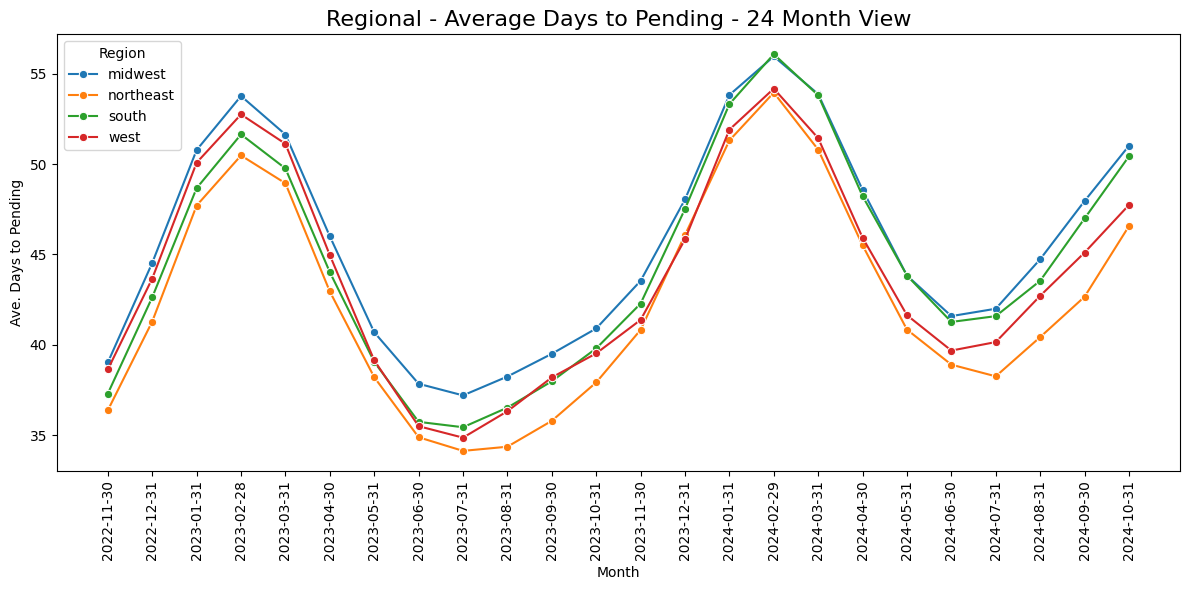

In [50]:
# PENDING - Melt the DataFrame for easier plotting
df_melted_pending = pd.melt(grouped_df_duration_pending, id_vars=["region"], var_name="Month", value_name="Ave. Days to Pending")

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_melted_pending, x="Month", y="Ave. Days to Pending", hue="region", marker="o")

# Customize the plot
plt.title("Regional - Average Days to Pending - 24 Month View", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Ave. Days to Pending")
plt.xticks(rotation=90)
plt.legend(title="Region")
plt.tight_layout()

# Show plot
plt.show()


### I WAS THINKING OF ADDING A BOXPLOT HERE TO HIGHLIGHT THE (IN?)SIGNIFICANCE IN AVERAGE DAYS TO PENDING

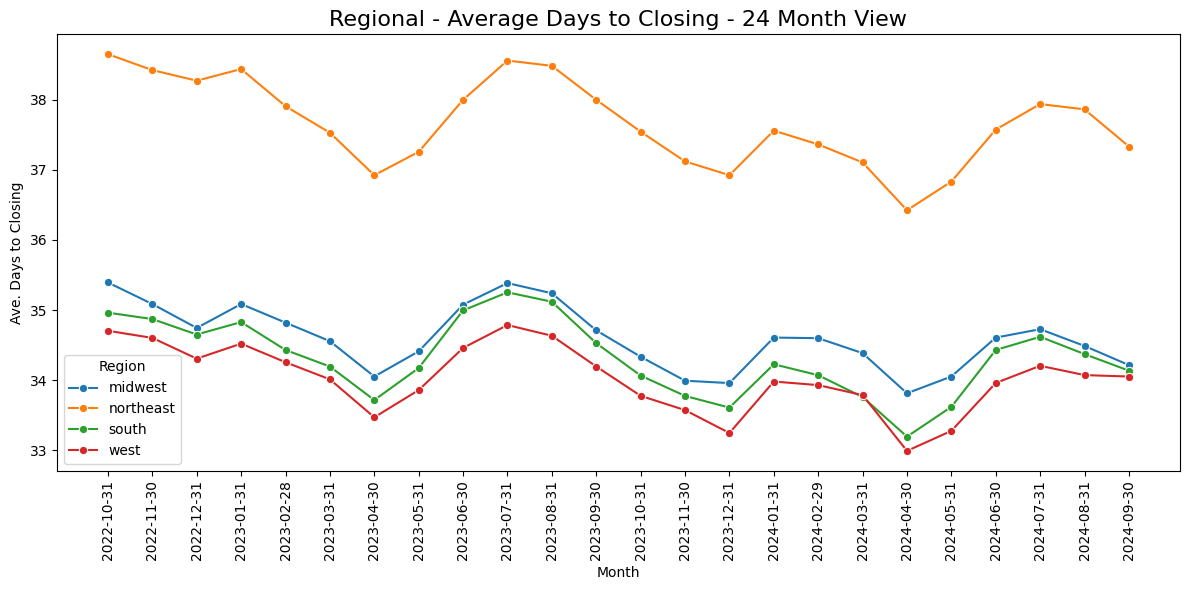

In [51]:
# MEAN CLOSING DATE DATA - Melt the DataFrame for easier plotting
df_melted_closing = pd.melt(grouped_df_duration_closing, id_vars=["region"], var_name="Month", value_name="Ave. Days to Closing")

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_melted_closing, x="Month", y="Ave. Days to Closing", hue="region", marker="o")

# Customize the plot
plt.title("Regional - Average Days to Closing - 24 Month View", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Ave. Days to Closing")
plt.xticks(rotation=90)
plt.legend(title="Region")
plt.tight_layout()

# Show plot
plt.show()


### I WAS THINKING OF ADDING BOXPLOTS HERE TO HIGHLIGHT THE SIGNIFICANCE IN AVERAGE DAYS TO CLOSING

## Q4) Market Durations by Region - Line Plot Conclusions
* Northeast properties move to 'sale pending' status more quickly than other regions
* However, Northeast properties are much slower when moving to the 'sale close' status compared to the other regions
* Midwest, South, and West properties are all fairly similar in average days to close

Q5 How much average profit I could expect from my investments in terms of sale (% dollars) after paying mortgage. Calculate my ~ROI. 10 Points

## Question 5: Average Profit Expected from Selling
Data Type: Median Sale Price(Raw,SFR only,Monthly) 

Assumptions before calculation: 
Mortage interest rate is 7% of the purchase price

In [52]:
# Load the data
df= pd.read_csv("data/Metro_median_sale_price_uc_sfr_month.csv")

display(df.head(5))  
display(df.tail(5))
display(df.count())

,RegionID,SizeRank,RegionName,RegionType,StateName,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
0,102001,0,United States,country,NaN,167000.0,172800.0,174610.0,177000.0,182000.0,...,325000.0,325000.0,336500.0,349000.0,355000.0,365000.0,375000.0,367951.0,365000.0,359000.0
1,394913,1,"New York, NY",msa,NY,400000.0,395000.0,395000.0,400000.0,405000.0,...,600000.0,600000.0,595000.0,600000.0,620000.0,645000.0,675000.0,675000.0,675000.0,665000.0
2,753899,2,"Los Angeles, CA",msa,CA,500000.0,483000.0,487000.0,470000.0,455000.0,...,890000.0,885000.0,940000.0,943000.0,970000.0,1000000.0,988000.0,975000.0,950000.0,931500.0
3,394463,3,"Chicago, IL",msa,IL,215000.0,222000.0,224000.0,230000.0,239000.0,...,285000.0,284900.0,290000.0,308000.0,320000.0,329000.0,344950.0,339900.0,325000.0,325000.0
4,394514,4,"Dallas, TX",msa,TX,138048.0,146680.0,145000.0,150000.0,156500.0,...,370000.0,370000.0,383000.0,395000.0,400000.0,407500.0,405000.0,400000.0,395000.0,385000.0


,RegionID,SizeRank,RegionName,RegionType,StateName,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
715,394418,880,"Brookings, OR",msa,OR,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,400000.0,435000.0,422500.0,450000.0,432500.0,463500.0,465000.0
716,753914,908,"Port Lavaca, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128250.0
717,753925,910,"Vineyard Haven, MA",msa,MA,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500000.0,1785000.0
718,394805,916,"Los Alamos, NM",msa,NM,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,720000.0,627000.0,620000.0,581477.0,537000.0,568000.0,622500.0
719,395112,922,"Spirit Lake, IA",msa,IA,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,366500.0,350000.0,365500.0,424500.0,406000.0,359750.0,494950.0


RegionID      720
SizeRank      720
RegionName    720
RegionType    720
StateName     719
             ... 
2024-05-31    710
2024-06-30    710
2024-07-31    713
2024-08-31    717
2024-09-30    720
Length: 205, dtype: int64

Q6) How much average monthly income I could expect from my investments in terms of lease/rent after upgrading properties, paying mortgage, and paying taxes. Calculate my ~ROI.

In [53]:
# List number of rows
print("Before: number of rows: ", df.shape)
 
# Drop the duplicates - (no duplicates found)
df = df.drop_duplicates()
print("After: number of rows: ", df.shape)
 
# Drop Missing/Null Values (no null values found)
print("Sum of null values: ", df.isnull().sum())

# Drop rows with NaN values
display(df.count())
df = df.dropna() 
display(df.count())

display(df.head(5))
display(df.tail(5))

Before: number of rows:  (720, 205)
After: number of rows:  (720, 205)
Sum of null values:  RegionID       0
SizeRank       0
RegionName     0
RegionType     0
StateName      1
              ..
2024-05-31    10
2024-06-30    10
2024-07-31     7
2024-08-31     3
2024-09-30     0
Length: 205, dtype: int64


RegionID      720
SizeRank      720
RegionName    720
RegionType    720
StateName     719
             ... 
2024-05-31    710
2024-06-30    710
2024-07-31    713
2024-08-31    717
2024-09-30    720
Length: 205, dtype: int64

RegionID      445
SizeRank      445
RegionName    445
RegionType    445
StateName     445
             ... 
2024-05-31    445
2024-06-30    445
2024-07-31    445
2024-08-31    445
2024-09-30    445
Length: 205, dtype: int64

,RegionID,SizeRank,RegionName,RegionType,StateName,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
1,394913,1,"New York, NY",msa,NY,400000.0,395000.0,395000.0,400000.0,405000.0,...,600000.0,600000.0,595000.0,600000.0,620000.0,645000.0,675000.0,675000.0,675000.0,665000.0
2,753899,2,"Los Angeles, CA",msa,CA,500000.0,483000.0,487000.0,470000.0,455000.0,...,890000.0,885000.0,940000.0,943000.0,970000.0,1000000.0,988000.0,975000.0,950000.0,931500.0
3,394463,3,"Chicago, IL",msa,IL,215000.0,222000.0,224000.0,230000.0,239000.0,...,285000.0,284900.0,290000.0,308000.0,320000.0,329000.0,344950.0,339900.0,325000.0,325000.0
4,394514,4,"Dallas, TX",msa,TX,138048.0,146680.0,145000.0,150000.0,156500.0,...,370000.0,370000.0,383000.0,395000.0,400000.0,407500.0,405000.0,400000.0,395000.0,385000.0
6,395209,6,"Washington, DC",msa,VA,355000.0,347000.0,345000.0,350000.0,350000.0,...,525001.0,510000.0,545000.0,580000.0,615000.0,625000.0,624000.0,610000.0,596500.0,580000.0


,RegionID,SizeRank,RegionName,RegionType,StateName,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
594,753889,645,"Hillsdale, MI",msa,MI,85900.0,82200.0,61950.0,77000.0,65000.0,...,124000.0,150000.0,161000.0,130000.0,199000.0,162000.0,187600.0,187500.0,175000.0,162550.0
611,394779,665,"Lawrenceburg, TN",msa,TN,73250.0,69419.0,57000.0,58750.0,78500.0,...,150000.0,199900.0,205000.0,212000.0,220000.0,193000.0,250000.0,219900.0,200000.0,236053.0
629,394845,690,"McMinnville, TN",msa,TN,63500.0,65000.0,64500.0,72500.0,61650.0,...,200000.0,230000.0,225900.0,225000.0,225000.0,234000.0,238750.0,226950.0,230000.0,252000.0
663,394745,744,"Kill Devil Hills, NC",msa,NC,302500.0,345000.0,327000.0,355000.0,355000.0,...,714500.0,655000.0,625000.0,615000.0,620000.0,680000.0,625000.0,657500.0,700000.0,660000.0
682,394786,783,"Lewisburg, TN",msa,TN,85850.0,107844.0,101267.0,85000.0,80000.0,...,330450.0,239900.0,348250.0,267000.0,312900.0,322500.0,345850.0,354200.0,285500.0,375000.0


In [54]:
# Rename column headers to snake_case and more appropriate terms
df = df.rename(columns={"RegionID": "region_id", 
                        "SizeRank": "size_rank", 
                        "RegionName": "metro_area",
                        "RegionType": "region_type",
                        "StateName": "state_name"})
                        
df.head(5)

# View a column to confirm the suspicion that the data is redundant/repeated or simply not needed
display(df['metro_area'].unique())

# Drop unnecessary columns
df = df.drop(["region_id", "size_rank", "region_type"], axis=1)
display(df.head(5))

array(['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Dallas, TX',
       'Washington, DC', 'Philadelphia, PA', 'Miami, FL', 'Atlanta, GA',
       'Boston, MA', 'Phoenix, AZ', 'San Francisco, CA', 'Riverside, CA',
       'Detroit, MI', 'Seattle, WA', 'Minneapolis, MN', 'San Diego, CA',
       'Tampa, FL', 'Denver, CO', 'Baltimore, MD', 'St. Louis, MO',
       'Orlando, FL', 'Charlotte, NC', 'San Antonio, TX', 'Portland, OR',
       'Sacramento, CA', 'Pittsburgh, PA', 'Cincinnati, OH', 'Austin, TX',
       'Las Vegas, NV', 'Kansas City, MO', 'Indianapolis, IN',
       'Cleveland, OH', 'San Jose, CA', 'Nashville, TN',
       'Virginia Beach, VA', 'Providence, RI', 'Jacksonville, FL',
       'Milwaukee, WI', 'Oklahoma City, OK', 'Raleigh, NC', 'Memphis, TN',
       'Richmond, VA', 'Louisville, KY', 'New Orleans, LA',
       'Salt Lake City, UT', 'Hartford, CT', 'Buffalo, NY',
       'Birmingham, AL', 'Rochester, NY', 'Grand Rapids, MI',
       'Tucson, AZ', 'Urban Honolulu, HI', 'Tuls

,metro_area,state_name,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
1,"New York, NY",NY,400000.0,395000.0,395000.0,400000.0,405000.0,420000.0,417000.0,385000.0,...,600000.0,600000.0,595000.0,600000.0,620000.0,645000.0,675000.0,675000.0,675000.0,665000.0
2,"Los Angeles, CA",CA,500000.0,483000.0,487000.0,470000.0,455000.0,437000.0,424500.0,395000.0,...,890000.0,885000.0,940000.0,943000.0,970000.0,1000000.0,988000.0,975000.0,950000.0,931500.0
3,"Chicago, IL",IL,215000.0,222000.0,224000.0,230000.0,239000.0,235000.0,235000.0,210000.0,...,285000.0,284900.0,290000.0,308000.0,320000.0,329000.0,344950.0,339900.0,325000.0,325000.0
4,"Dallas, TX",TX,138048.0,146680.0,145000.0,150000.0,156500.0,154305.0,150000.0,140000.0,...,370000.0,370000.0,383000.0,395000.0,400000.0,407500.0,405000.0,400000.0,395000.0,385000.0
6,"Washington, DC",VA,355000.0,347000.0,345000.0,350000.0,350000.0,340000.0,325000.0,290000.0,...,525001.0,510000.0,545000.0,580000.0,615000.0,625000.0,624000.0,610000.0,596500.0,580000.0


In [55]:
# Add a "Region" column

# Define the regions
northeast = ["CT", "ME", "MA", "NH", "RI", "VT", "NJ", "NY", "PA"]
midwest = ["IL", "IN", "IA", "KS", "MI", "MN", "MO", "NE", "ND", "OH", "SD", "WI"]
south = ["AL", "AR", "DE", "FL", "GA", "KY", "LA", "MD", "MS", "NC", "OK", "SC", "TN", "TX", "VA", "WV"]
west = ["AK", "AZ", "CA", "CO", "HI", "ID", "MT", "NV", "NM", "OR", "UT", "WA", "WY"]

# Map states to regions
region_map = {}
region_map.update({state: "northeast" for state in northeast})
region_map.update({state: "midwest" for state in midwest})
region_map.update({state: "south" for state in south})
region_map.update({state: "west" for state in west})

display(region_map)

# Add the Region column
df.insert(2, "region", df["state_name"].map(region_map))

df.head(5)

{'CT': 'northeast',
 'ME': 'northeast',
 'MA': 'northeast',
 'NH': 'northeast',
 'RI': 'northeast',
 'VT': 'northeast',
 'NJ': 'northeast',
 'NY': 'northeast',
 'PA': 'northeast',
 'IL': 'midwest',
 'IN': 'midwest',
 'IA': 'midwest',
 'KS': 'midwest',
 'MI': 'midwest',
 'MN': 'midwest',
 'MO': 'midwest',
 'NE': 'midwest',
 'ND': 'midwest',
 'OH': 'midwest',
 'SD': 'midwest',
 'WI': 'midwest',
 'AL': 'south',
 'AR': 'south',
 'DE': 'south',
 'FL': 'south',
 'GA': 'south',
 'KY': 'south',
 'LA': 'south',
 'MD': 'south',
 'MS': 'south',
 'NC': 'south',
 'OK': 'south',
 'SC': 'south',
 'TN': 'south',
 'TX': 'south',
 'VA': 'south',
 'WV': 'south',
 'AK': 'west',
 'AZ': 'west',
 'CA': 'west',
 'CO': 'west',
 'HI': 'west',
 'ID': 'west',
 'MT': 'west',
 'NV': 'west',
 'NM': 'west',
 'OR': 'west',
 'UT': 'west',
 'WA': 'west',
 'WY': 'west'}

,metro_area,state_name,region,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
1,"New York, NY",NY,northeast,400000.0,395000.0,395000.0,400000.0,405000.0,420000.0,417000.0,...,600000.0,600000.0,595000.0,600000.0,620000.0,645000.0,675000.0,675000.0,675000.0,665000.0
2,"Los Angeles, CA",CA,west,500000.0,483000.0,487000.0,470000.0,455000.0,437000.0,424500.0,...,890000.0,885000.0,940000.0,943000.0,970000.0,1000000.0,988000.0,975000.0,950000.0,931500.0
3,"Chicago, IL",IL,midwest,215000.0,222000.0,224000.0,230000.0,239000.0,235000.0,235000.0,...,285000.0,284900.0,290000.0,308000.0,320000.0,329000.0,344950.0,339900.0,325000.0,325000.0
4,"Dallas, TX",TX,south,138048.0,146680.0,145000.0,150000.0,156500.0,154305.0,150000.0,...,370000.0,370000.0,383000.0,395000.0,400000.0,407500.0,405000.0,400000.0,395000.0,385000.0
6,"Washington, DC",VA,south,355000.0,347000.0,345000.0,350000.0,350000.0,340000.0,325000.0,...,525001.0,510000.0,545000.0,580000.0,615000.0,625000.0,624000.0,610000.0,596500.0,580000.0


In [56]:
# Drop any column over 5 years
df = df.drop(df.columns[3:-61], axis=1)
display(df.head(5))

,metro_area,state_name,region,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
1,"New York, NY",NY,northeast,413500.0,410000.0,410500.0,420000.0,423051.0,407500.0,415500.0,...,600000.0,600000.0,595000.0,600000.0,620000.0,645000.0,675000.0,675000.0,675000.0,665000.0
2,"Los Angeles, CA",CA,west,685500.0,680000.0,680000.0,691000.0,685000.0,705000.0,725000.0,...,890000.0,885000.0,940000.0,943000.0,970000.0,1000000.0,988000.0,975000.0,950000.0,931500.0
3,"Chicago, IL",IL,midwest,234900.0,235000.0,235000.0,234000.0,227000.0,231000.0,253000.0,...,285000.0,284900.0,290000.0,308000.0,320000.0,329000.0,344950.0,339900.0,325000.0,325000.0
4,"Dallas, TX",TX,south,262000.0,260000.0,259900.0,265000.0,256000.0,262000.0,270000.0,...,370000.0,370000.0,383000.0,395000.0,400000.0,407500.0,405000.0,400000.0,395000.0,385000.0
6,"Washington, DC",VA,south,405000.0,415900.0,420000.0,420000.0,400000.0,419900.0,445000.0,...,525001.0,510000.0,545000.0,580000.0,615000.0,625000.0,624000.0,610000.0,596500.0,580000.0


In [57]:
display(df.tail(5))

,metro_area,state_name,region,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
594,"Hillsdale, MI",MI,midwest,116750.0,125000.0,112000.0,131250.0,132500.0,134950.0,115000.0,...,124000.0,150000.0,161000.0,130000.0,199000.0,162000.0,187600.0,187500.0,175000.0,162550.0
611,"Lawrenceburg, TN",TN,south,98000.0,117800.0,118250.0,127500.0,147500.0,135555.0,130000.0,...,150000.0,199900.0,205000.0,212000.0,220000.0,193000.0,250000.0,219900.0,200000.0,236053.0
629,"McMinnville, TN",TN,south,124950.0,142450.0,120000.0,119750.0,120000.0,135000.0,129000.0,...,200000.0,230000.0,225900.0,225000.0,225000.0,234000.0,238750.0,226950.0,230000.0,252000.0
663,"Kill Devil Hills, NC",NC,south,337500.0,344500.0,362000.0,382000.0,356500.0,350000.0,364500.0,...,714500.0,655000.0,625000.0,615000.0,620000.0,680000.0,625000.0,657500.0,700000.0,660000.0
682,"Lewisburg, TN",TN,south,145000.0,200000.0,170000.0,164950.0,136254.0,167000.0,183950.0,...,330450.0,239900.0,348250.0,267000.0,312900.0,322500.0,345850.0,354200.0,285500.0,375000.0


## Calculate ROI for Sell

In [58]:
#Calculate ROI (ROI = profit / amount invest)
df['sale_income'] = df ['2024-09-30'] - df['2019-09-30'] #sale_income = 2024_sale_price - 2022_sale_price
purchase_price = df['2019-09-30'] #Assume this is the date to purchase the house
mortgage = purchase_price * 0.07
net_income = df ['sale_income'] - mortgage
total_investment = purchase_price + mortgage
df['ROI'] = net_income / total_investment
display (df.ROI)

1      0.503012
2      0.269965
3      0.293054
4      0.373332
6      0.338410
         ...   
594    0.301207
611    1.251125
629    0.884866
663    0.827622
682    1.417016
Name: ROI, Length: 445, dtype: float64

## 1. What does the ROI looks like in Four regions in the US?

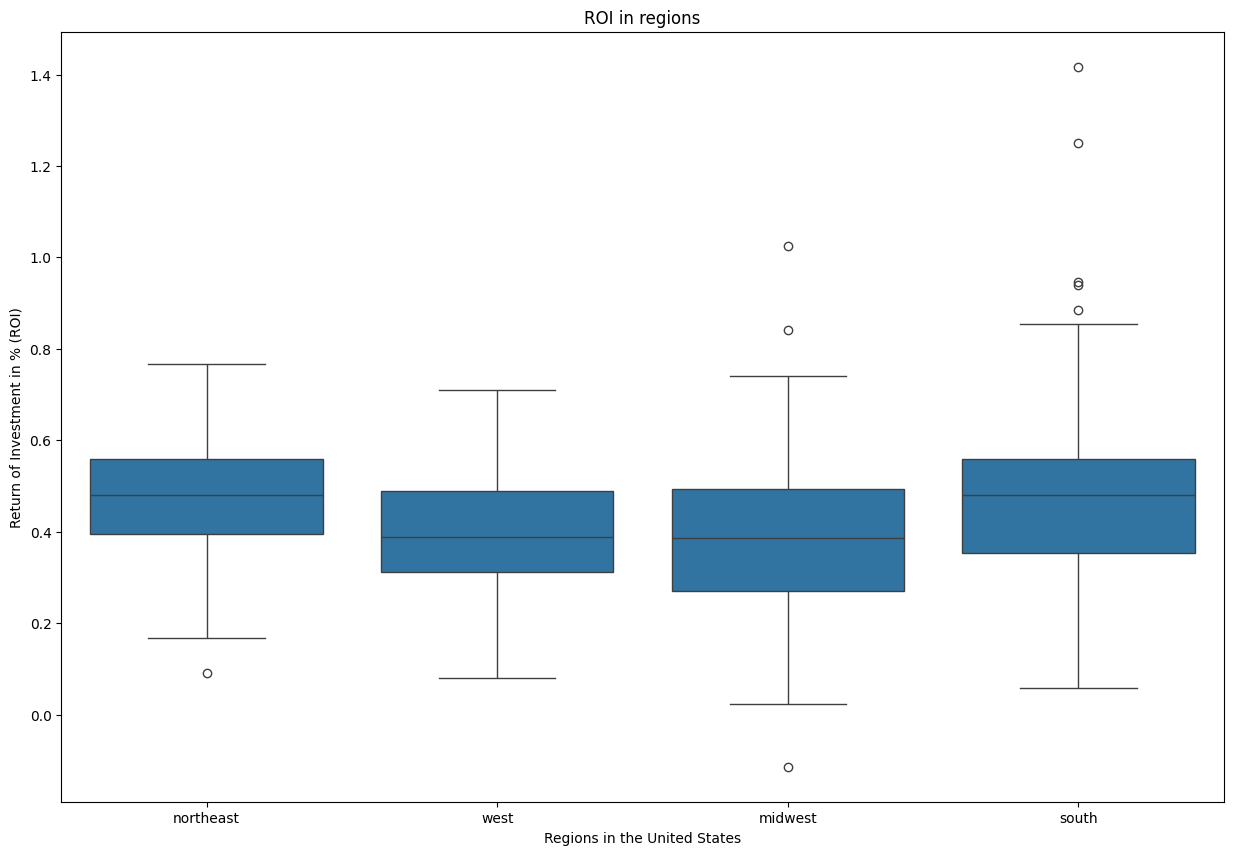

In [59]:
# Create box plots for ROI by region
fig, axes = plt.subplots(figsize=(15, 10))

sns.boxplot(x='region', y='ROI', data=df)
axes.set_title('ROI in regions')
axes.set_xlabel('Regions in the United States')
axes.set_ylabel('Return of Investment in % (ROI)')
plt.show()

## Conclusion for ROI in selling in Four Regions:
Between Quarter 3 of 2019 to Quarter 3 of 2024 in the United States: 
- Northeast has the most return of investment, which is around 42%. 
- South region ranks the second place with very close ROI to the Northeast
- Midwest ranks the last for ROI in selling a property
- To invest and then sell, purchase houses in northeast and south get around 42% returns of investment in the past 5 years

## 2. What does each state ROI in selling look like?

,ROI
state_name,
LA,0.186154
ND,0.217978
IL,0.219843
WV,0.285849
IA,0.288536
WY,0.298295
CA,0.301775
OK,0.306074
MS,0.327174


Text(0, 0.5, 'Regions')

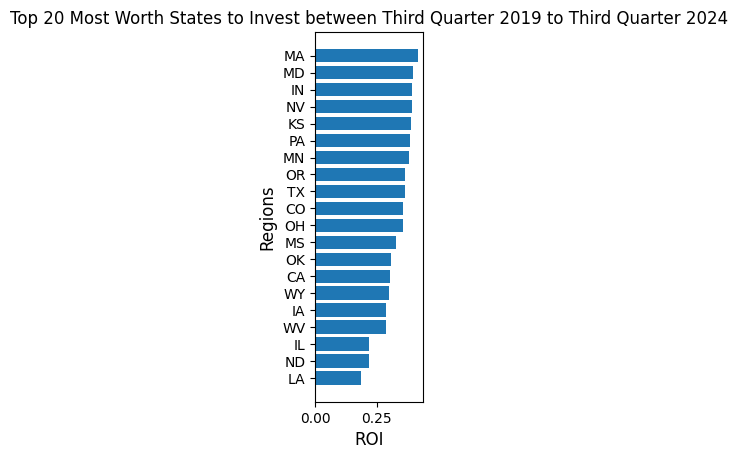

In [60]:
#Table for Top 20 ROI: 
pivot = df.pivot_table(index = ['state_name'],values = ['ROI'])
pivot = pivot.sort_values(by = 'ROI', ascending = True).head(20)
display(pivot)

#Chart for Top 20 ROI:
plt.subplot(1,4,1)
plt.barh(pivot.index,pivot['ROI'])
plt.title('Top 20 Most Worth States to Invest between Third Quarter 2019 to Third Quarter 2024')
plt.xlabel('ROI',fontsize=12)
plt.ylabel('Regions',fontsize=12)

## Conclusions for bar chart:
Between Quarter 3 of 2019 to Quarter 3 of 2024 in the United States: 
- The top 20 states ROI in selling is between 18%-41%
- Among the states in Northeast, Massachusetts houses has the most return of investment

## Final Conclusion for Average Profit for Sell: 
- You will expect different profit from selling house investments after paying for mortgage. With the analysis within four regions and among all states, we found that: 
1. Northeast and South region have very close high Return of Investment in selling in the past 5 years
2. In Northeast, Masschusetts is the most valuable state to invest
3. The top 20 states for return of investment rate is between 18%-42%

Q6) How much average monthly income I could expect from my investments in terms of lease/rent after upgrading properties, paying mortgage, and paying taxes. Calculate my ~ROI.

## Question 6: Average Monthly Income ROI
1. Data 1: ZORI(Smoothed): Single Family Residence Time Series($)
2. Data 2: Median Sale Price(Raw,SFR only,Monthly) 

In [61]:
# Load the Single Family Residence Time Data: 
df_rental = pd.read_csv('data/Metro_zori_uc_sfr_sm_month.csv')
display(df_rental.head(5))  
display(df_rental.tail(5))
display(df_rental.count())

,RegionID,SizeRank,RegionName,RegionType,StateName,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,102001,0,United States,country,NaN,1263.444318,1269.895092,1278.469237,1288.647487,1298.178017,...,2135.254699,2147.222455,2162.917331,2175.779343,2188.086209,2197.213557,2205.825071,2211.841814,2214.693266,2214.826710
1,394913,1,"New York, NY",msa,NY,2172.350813,2195.448862,2211.980362,2225.518207,2227.878842,...,3389.252812,3423.331146,3468.956765,3479.434471,3504.068770,3512.967752,3535.906708,3546.100645,3518.356703,3509.750205
2,753899,2,"Los Angeles, CA",msa,CA,2529.451523,2543.786170,2562.465252,2573.300077,2597.387056,...,4166.947559,4183.689748,4203.755348,4220.144971,4240.531898,4259.751366,4276.789066,4281.189374,4284.485193,4279.602359
3,394463,3,"Chicago, IL",msa,IL,1505.627017,1511.779272,1522.073950,1534.764157,1547.538133,...,2244.117798,2256.354170,2266.294085,2295.246104,2318.130388,2333.454844,2343.094047,2354.724901,2360.133093,2366.401698
4,394514,4,"Dallas, TX",msa,TX,1370.989564,1379.417484,1389.001222,1403.596165,1416.346007,...,2280.897967,2285.831609,2304.134514,2317.396859,2324.499356,2328.954287,2333.301355,2336.420733,2335.093773,2328.929081


,RegionID,SizeRank,RegionName,RegionType,StateName,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
517,394615,847,"Fredericksburg, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2675.000000
518,753923,849,"The Dalles, OR",msa,OR,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1740.102792,1778.803237,1835.966779,1941.666667
519,753921,867,"Steamboat Springs, CO",msa,CO,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5562.963657,5104.611225,4785.778907,4536.559011,4611.274908,4656.828202,4622.833333
520,394996,915,"Portales, NM",msa,NM,NaN,NaN,NaN,NaN,NaN,...,1094.005403,1069.62567,1058.636768,1072.369019,1100.772818,1136.945351,1136.186990,1128.202788,1118.693907,1123.888889
521,394805,916,"Los Alamos, NM",msa,NM,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2634.324739,2750.000000


RegionID      522
SizeRank      522
RegionName    522
RegionType    522
StateName     521
             ... 
2024-06-30    442
2024-07-31    455
2024-08-31    466
2024-09-30    483
2024-10-31    522
Length: 123, dtype: int64

In [62]:
# List number of rows
print("Before: number of rows: ", df_rental.shape)
 
# Drop the duplicates - (no duplicates found)
df_rental = df_rental.drop_duplicates()
print("After: number of rows: ", df_rental.shape)
 
# Drop Missing/Null Values (no null values found)
print("Sum of null values: ", df_rental.isnull().sum())

# Drop rows with NaN values
display(df_rental.count())
df_rental = df_rental.dropna() 
display(df_rental.count())

display(df_rental.head(5))
display(df_rental.tail(5))

Before: number of rows:  (522, 123)
After: number of rows:  (522, 123)
Sum of null values:  RegionID       0
SizeRank       0
RegionName     0
RegionType     0
StateName      1
              ..
2024-06-30    80
2024-07-31    67
2024-08-31    56
2024-09-30    39
2024-10-31     0
Length: 123, dtype: int64


RegionID      522
SizeRank      522
RegionName    522
RegionType    522
StateName     521
             ... 
2024-06-30    442
2024-07-31    455
2024-08-31    466
2024-09-30    483
2024-10-31    522
Length: 123, dtype: int64

RegionID      168
SizeRank      168
RegionName    168
RegionType    168
StateName     168
             ... 
2024-06-30    168
2024-07-31    168
2024-08-31    168
2024-09-30    168
2024-10-31    168
Length: 123, dtype: int64

,RegionID,SizeRank,RegionName,RegionType,StateName,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
1,394913,1,"New York, NY",msa,NY,2172.350813,2195.448862,2211.980362,2225.518207,2227.878842,...,3389.252812,3423.331146,3468.956765,3479.434471,3504.068770,3512.967752,3535.906708,3546.100645,3518.356703,3509.750205
2,753899,2,"Los Angeles, CA",msa,CA,2529.451523,2543.786170,2562.465252,2573.300077,2597.387056,...,4166.947559,4183.689748,4203.755348,4220.144971,4240.531898,4259.751366,4276.789066,4281.189374,4284.485193,4279.602359
3,394463,3,"Chicago, IL",msa,IL,1505.627017,1511.779272,1522.073950,1534.764157,1547.538133,...,2244.117798,2256.354170,2266.294085,2295.246104,2318.130388,2333.454844,2343.094047,2354.724901,2360.133093,2366.401698
4,394514,4,"Dallas, TX",msa,TX,1370.989564,1379.417484,1389.001222,1403.596165,1416.346007,...,2280.897967,2285.831609,2304.134514,2317.396859,2324.499356,2328.954287,2333.301355,2336.420733,2335.093773,2328.929081
5,394692,5,"Houston, TX",msa,TX,1492.797146,1498.246621,1505.909295,1517.078518,1528.492786,...,2068.538636,2081.822525,2092.298563,2104.151103,2111.464305,2121.015668,2126.946470,2132.802905,2134.536004,2135.578001


,RegionID,SizeRank,RegionName,RegionType,StateName,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
301,395232,308,"Winchester, VA",msa,VA,1145.776587,1153.162526,1164.373918,1168.422721,1162.329486,...,1953.541383,1945.117885,1982.545419,1980.796761,2024.943078,2012.477605,2053.287946,2049.810927,2056.976348,2037.152778
313,394821,320,"Manhattan, KS",msa,KS,1098.990540,1099.689319,1103.371476,1102.054924,1105.422440,...,1331.858102,1327.249427,1341.716096,1341.478901,1357.192014,1368.966765,1391.326380,1396.869926,1397.747972,1385.842232
323,394780,332,"Lawton, OK",msa,OK,705.307577,704.138341,710.523548,709.337651,713.615888,...,1028.806684,1054.191616,1058.888809,1055.043677,1059.004739,1079.286781,1078.384000,1086.909713,1087.883929,1101.883754
366,394462,391,"Cheyenne, WY",msa,WY,1186.886792,1188.676909,1211.724188,1217.124399,1214.192552,...,1724.470977,1744.161450,1740.605355,1751.330335,1778.063663,1792.656120,1792.539381,1774.081339,1775.017612,1780.456031
389,394925,428,"Oak Harbor, WA",msa,WA,1211.511572,1234.470612,1245.467722,1285.180681,1297.759311,...,2416.450227,2409.128380,2412.385991,2457.352131,2491.551026,2525.687512,2538.202551,2543.106779,2558.499234,2527.425926


In [63]:
# Rename column headers to snake_case and more appropriate terms
df_rental = df_rental.rename(columns={"RegionID": "region_id", 
                        "SizeRank": "size_rank", 
                        "RegionName": "metro_area",
                        "RegionType": "region_type",
                        "StateName": "state_name"})
                        
df_rental.head(5)

# View a column to confirm the suspicion that the data is redundant/repeated or simply not needed
display(df_rental['state_name'].unique())

# Drop unnecessary columns
df_rental = df_rental.drop(["region_id","size_rank", "region_type"], axis=1)
display(df_rental.head(5))

array(['NY', 'CA', 'IL', 'TX', 'VA', 'PA', 'FL', 'GA', 'MA', 'AZ', 'MI',
       'WA', 'MN', 'CO', 'MD', 'MO', 'NC', 'OR', 'OH', 'NV', 'IN', 'TN',
       'RI', 'WI', 'OK', 'KY', 'LA', 'UT', 'CT', 'AL', 'HI', 'NE', 'SC',
       'NM', 'ID', 'AR', 'IA', 'KS', 'MS', 'AK', 'NJ', 'WY'], dtype=object)

,metro_area,state_name,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
1,"New York, NY",NY,2172.350813,2195.448862,2211.980362,2225.518207,2227.878842,2244.158650,2249.784555,2250.106962,...,3389.252812,3423.331146,3468.956765,3479.434471,3504.068770,3512.967752,3535.906708,3546.100645,3518.356703,3509.750205
2,"Los Angeles, CA",CA,2529.451523,2543.786170,2562.465252,2573.300077,2597.387056,2616.032336,2637.634665,2648.906697,...,4166.947559,4183.689748,4203.755348,4220.144971,4240.531898,4259.751366,4276.789066,4281.189374,4284.485193,4279.602359
3,"Chicago, IL",IL,1505.627017,1511.779272,1522.073950,1534.764157,1547.538133,1556.765533,1558.184208,1557.713346,...,2244.117798,2256.354170,2266.294085,2295.246104,2318.130388,2333.454844,2343.094047,2354.724901,2360.133093,2366.401698
4,"Dallas, TX",TX,1370.989564,1379.417484,1389.001222,1403.596165,1416.346007,1427.186591,1435.273497,1438.956655,...,2280.897967,2285.831609,2304.134514,2317.396859,2324.499356,2328.954287,2333.301355,2336.420733,2335.093773,2328.929081
5,"Houston, TX",TX,1492.797146,1498.246621,1505.909295,1517.078518,1528.492786,1538.965848,1541.572916,1541.820917,...,2068.538636,2081.822525,2092.298563,2104.151103,2111.464305,2121.015668,2126.946470,2132.802905,2134.536004,2135.578001


In [64]:
df_median_sale_price = pd.read_csv('data/Metro_median_sale_price_uc_sfr_month.csv')
df_median_sale_price.head(5)

,RegionID,SizeRank,RegionName,RegionType,StateName,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
0,102001,0,United States,country,NaN,167000.0,172800.0,174610.0,177000.0,182000.0,...,325000.0,325000.0,336500.0,349000.0,355000.0,365000.0,375000.0,367951.0,365000.0,359000.0
1,394913,1,"New York, NY",msa,NY,400000.0,395000.0,395000.0,400000.0,405000.0,...,600000.0,600000.0,595000.0,600000.0,620000.0,645000.0,675000.0,675000.0,675000.0,665000.0
2,753899,2,"Los Angeles, CA",msa,CA,500000.0,483000.0,487000.0,470000.0,455000.0,...,890000.0,885000.0,940000.0,943000.0,970000.0,1000000.0,988000.0,975000.0,950000.0,931500.0
3,394463,3,"Chicago, IL",msa,IL,215000.0,222000.0,224000.0,230000.0,239000.0,...,285000.0,284900.0,290000.0,308000.0,320000.0,329000.0,344950.0,339900.0,325000.0,325000.0
4,394514,4,"Dallas, TX",msa,TX,138048.0,146680.0,145000.0,150000.0,156500.0,...,370000.0,370000.0,383000.0,395000.0,400000.0,407500.0,405000.0,400000.0,395000.0,385000.0


In [65]:
# List number of rows
print("Before: number of rows: ", df_median_sale_price.shape)
 
# Drop the duplicates
df_median_sale_price = df_median_sale_price.drop_duplicates()
print("After: number of rows: ", df_median_sale_price.shape)
 
# Drop Missing/Null Values 
print("Sum of null values: ", df_median_sale_price.isnull().sum())

# Drop rows with NaN values
display(df_median_sale_price.count())
df_median_sale_price = df_median_sale_price.dropna() 
display(df_median_sale_price.count())

display(df_median_sale_price.head(5))
display(df_median_sale_price.tail(5))

Before: number of rows:  (720, 205)
After: number of rows:  (720, 205)
Sum of null values:  RegionID       0
SizeRank       0
RegionName     0
RegionType     0
StateName      1
              ..
2024-05-31    10
2024-06-30    10
2024-07-31     7
2024-08-31     3
2024-09-30     0
Length: 205, dtype: int64


RegionID      720
SizeRank      720
RegionName    720
RegionType    720
StateName     719
             ... 
2024-05-31    710
2024-06-30    710
2024-07-31    713
2024-08-31    717
2024-09-30    720
Length: 205, dtype: int64

RegionID      445
SizeRank      445
RegionName    445
RegionType    445
StateName     445
             ... 
2024-05-31    445
2024-06-30    445
2024-07-31    445
2024-08-31    445
2024-09-30    445
Length: 205, dtype: int64

,RegionID,SizeRank,RegionName,RegionType,StateName,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
1,394913,1,"New York, NY",msa,NY,400000.0,395000.0,395000.0,400000.0,405000.0,...,600000.0,600000.0,595000.0,600000.0,620000.0,645000.0,675000.0,675000.0,675000.0,665000.0
2,753899,2,"Los Angeles, CA",msa,CA,500000.0,483000.0,487000.0,470000.0,455000.0,...,890000.0,885000.0,940000.0,943000.0,970000.0,1000000.0,988000.0,975000.0,950000.0,931500.0
3,394463,3,"Chicago, IL",msa,IL,215000.0,222000.0,224000.0,230000.0,239000.0,...,285000.0,284900.0,290000.0,308000.0,320000.0,329000.0,344950.0,339900.0,325000.0,325000.0
4,394514,4,"Dallas, TX",msa,TX,138048.0,146680.0,145000.0,150000.0,156500.0,...,370000.0,370000.0,383000.0,395000.0,400000.0,407500.0,405000.0,400000.0,395000.0,385000.0
6,395209,6,"Washington, DC",msa,VA,355000.0,347000.0,345000.0,350000.0,350000.0,...,525001.0,510000.0,545000.0,580000.0,615000.0,625000.0,624000.0,610000.0,596500.0,580000.0


,RegionID,SizeRank,RegionName,RegionType,StateName,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
594,753889,645,"Hillsdale, MI",msa,MI,85900.0,82200.0,61950.0,77000.0,65000.0,...,124000.0,150000.0,161000.0,130000.0,199000.0,162000.0,187600.0,187500.0,175000.0,162550.0
611,394779,665,"Lawrenceburg, TN",msa,TN,73250.0,69419.0,57000.0,58750.0,78500.0,...,150000.0,199900.0,205000.0,212000.0,220000.0,193000.0,250000.0,219900.0,200000.0,236053.0
629,394845,690,"McMinnville, TN",msa,TN,63500.0,65000.0,64500.0,72500.0,61650.0,...,200000.0,230000.0,225900.0,225000.0,225000.0,234000.0,238750.0,226950.0,230000.0,252000.0
663,394745,744,"Kill Devil Hills, NC",msa,NC,302500.0,345000.0,327000.0,355000.0,355000.0,...,714500.0,655000.0,625000.0,615000.0,620000.0,680000.0,625000.0,657500.0,700000.0,660000.0
682,394786,783,"Lewisburg, TN",msa,TN,85850.0,107844.0,101267.0,85000.0,80000.0,...,330450.0,239900.0,348250.0,267000.0,312900.0,322500.0,345850.0,354200.0,285500.0,375000.0


In [66]:
# Rename column headers to snake_case and more appropriate terms
df_median_sale_price = df_median_sale_price.rename(columns={"RegionID": "region_id", 
                        "SizeRank": "size_rank", 
                        "RegionName": "metro_area",
                        "RegionType": "region_type",
                        "StateName": "state_name"})
                        
df_median_sale_price.head(5)

# View a column to confirm the suspicion that the data is redundant/repeated or simply not needed
display(df_median_sale_price['state_name'].unique())

# Drop unnecessary columns
df_median_sale_price = df_median_sale_price.drop(["region_id","size_rank", "region_type"], axis=1)
display(df_median_sale_price.head(5))

array(['NY', 'CA', 'IL', 'TX', 'VA', 'PA', 'FL', 'GA', 'MA', 'AZ', 'MI',
       'WA', 'MN', 'CO', 'MD', 'MO', 'NC', 'OR', 'OH', 'NV', 'IN', 'TN',
       'RI', 'WI', 'OK', 'KY', 'LA', 'UT', 'CT', 'AL', 'HI', 'NE', 'SC',
       'NM', 'ID', 'AR', 'IA', 'KS', 'MS', 'ME', 'NH', 'DE', 'NJ', 'WV',
       'ND', 'VT', 'MT', 'WY'], dtype=object)

,metro_area,state_name,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
1,"New York, NY",NY,400000.0,395000.0,395000.0,400000.0,405000.0,420000.0,417000.0,385000.0,...,600000.0,600000.0,595000.0,600000.0,620000.0,645000.0,675000.0,675000.0,675000.0,665000.0
2,"Los Angeles, CA",CA,500000.0,483000.0,487000.0,470000.0,455000.0,437000.0,424500.0,395000.0,...,890000.0,885000.0,940000.0,943000.0,970000.0,1000000.0,988000.0,975000.0,950000.0,931500.0
3,"Chicago, IL",IL,215000.0,222000.0,224000.0,230000.0,239000.0,235000.0,235000.0,210000.0,...,285000.0,284900.0,290000.0,308000.0,320000.0,329000.0,344950.0,339900.0,325000.0,325000.0
4,"Dallas, TX",TX,138048.0,146680.0,145000.0,150000.0,156500.0,154305.0,150000.0,140000.0,...,370000.0,370000.0,383000.0,395000.0,400000.0,407500.0,405000.0,400000.0,395000.0,385000.0
6,"Washington, DC",VA,355000.0,347000.0,345000.0,350000.0,350000.0,340000.0,325000.0,290000.0,...,525001.0,510000.0,545000.0,580000.0,615000.0,625000.0,624000.0,610000.0,596500.0,580000.0


In [67]:
# Drop any column over 5 years old
df_rental_dropped= df_rental.drop(df_rental.columns[2:-61], axis=1)
display(df_rental_dropped.head(5))

df_median_sale_price_dropped=df_median_sale_price.drop(df_median_sale_price.columns[2:-61], axis=1)
display(df_median_sale_price_dropped.head(5))

,metro_area,state_name,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
1,"New York, NY",NY,2555.455137,2561.984679,2586.834295,2588.391550,2601.705984,2614.296366,2634.741790,2650.867915,...,3389.252812,3423.331146,3468.956765,3479.434471,3504.068770,3512.967752,3535.906708,3546.100645,3518.356703,3509.750205
2,"Los Angeles, CA",CA,3178.448076,3184.910951,3193.339131,3207.169191,3221.061211,3226.879689,3214.568641,3214.750073,...,4166.947559,4183.689748,4203.755348,4220.144971,4240.531898,4259.751366,4276.789066,4281.189374,4284.485193,4279.602359
3,"Chicago, IL",IL,1719.538822,1715.526435,1711.127365,1714.863513,1726.617816,1740.192738,1747.297558,1752.087825,...,2244.117798,2256.354170,2266.294085,2295.246104,2318.130388,2333.454844,2343.094047,2354.724901,2360.133093,2366.401698
4,"Dallas, TX",TX,1687.264769,1688.488972,1687.007204,1691.171967,1697.043234,1709.314152,1712.236426,1718.264929,...,2280.897967,2285.831609,2304.134514,2317.396859,2324.499356,2328.954287,2333.301355,2336.420733,2335.093773,2328.929081
5,"Houston, TX",TX,1643.407167,1643.159851,1643.113966,1646.734023,1652.731964,1660.583158,1661.871643,1665.999303,...,2068.538636,2081.822525,2092.298563,2104.151103,2111.464305,2121.015668,2126.946470,2132.802905,2134.536004,2135.578001


,metro_area,state_name,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
1,"New York, NY",NY,413500.0,410000.0,410500.0,420000.0,423051.0,407500.0,415500.0,435000.0,...,600000.0,600000.0,595000.0,600000.0,620000.0,645000.0,675000.0,675000.0,675000.0,665000.0
2,"Los Angeles, CA",CA,685500.0,680000.0,680000.0,691000.0,685000.0,705000.0,725000.0,700000.0,...,890000.0,885000.0,940000.0,943000.0,970000.0,1000000.0,988000.0,975000.0,950000.0,931500.0
3,"Chicago, IL",IL,234900.0,235000.0,235000.0,234000.0,227000.0,231000.0,253000.0,261500.0,...,285000.0,284900.0,290000.0,308000.0,320000.0,329000.0,344950.0,339900.0,325000.0,325000.0
4,"Dallas, TX",TX,262000.0,260000.0,259900.0,265000.0,256000.0,262000.0,270000.0,280000.0,...,370000.0,370000.0,383000.0,395000.0,400000.0,407500.0,405000.0,400000.0,395000.0,385000.0
6,"Washington, DC",VA,405000.0,415900.0,420000.0,420000.0,400000.0,419900.0,445000.0,460000.0,...,525001.0,510000.0,545000.0,580000.0,615000.0,625000.0,624000.0,610000.0,596500.0,580000.0


In [68]:
# Set index:
df_rental_dropped = df_rental_dropped.set_index('metro_area')
df_median_sale_price_dropped = df_median_sale_price_dropped.set_index('metro_area')

In [69]:
# Merge two dataframes: 
df_merged = pd.merge(df_rental.iloc[:,-1], df_median_sale_price.iloc[:,-1], left_index=True, right_index=True)
df_merged = pd.merge(df_rental.iloc[:,0], df_merged, left_index=True, right_index=True)

df_merged.rename(columns={df_merged.columns[0]: 'Metro_Area', 
                          df_merged.columns[1]: 'Monthly_Rent', 
                          df_merged.columns[2]: 'Sale_Price'}, inplace=True)
display(df_merged.head(5))

,Metro_Area,Monthly_Rent,Sale_Price
1,"New York, NY",3509.750205,665000.0
2,"Los Angeles, CA",4279.602359,931500.0
3,"Chicago, IL",2366.401698,325000.0
4,"Dallas, TX",2328.929081,385000.0
6,"Washington, DC",3074.618169,580000.0


## Calculate ROI in Rental:
Assumption:

1. Downpayment: 20% of the sale price
2. Closing costs = $2500
3. Remodeling: 5% of the sale price
4. Mortage rate: 6%
5. Taxes: increase 1% of the sale price every year
6. Insurances: increase 1% of the sale price every year

In [70]:
def roi_cal(df):
    downpayment = df['Sale_Price'] * 0.2
    closing_costs = 2500
    remodeling = df['Sale_Price'] * 0.05
    investment = downpayment + closing_costs + remodeling
    # Monthly Mortgage Payment:
    principle = df['Sale_Price'] - downpayment
    interest_rate = 0.06
    r = interest_rate / 12  # monthly interest rate
    n = 360  # number of monthly payments
    mortgage_payment = (principle * r * (1+r)**n) / ((1+r)**n - 1)
    # Monthly costs of insurance and property taxes:
    annual_insurance = df['Sale_Price'] * 0.01
    annual_taxes = df['Sale_Price'] * 0.01
    monthly_expenses = (annual_insurance + annual_taxes) / 12
    monthly_cash_flow = df['Monthly_Rent'] - mortgage_payment - monthly_expenses
    annual_return = monthly_cash_flow * 12
    # ROI for Rentals:
    df['ROI_rental'] = annual_return / investment
    return df
 

In [71]:
modified_df = roi_cal(df_merged)

display(modified_df)

,Metro_Area,Monthly_Rent,Sale_Price,ROI_rental
1,"New York, NY",3509.750205,665000.0,-0.056049
2,"Los Angeles, CA",4279.602359,931500.0,-0.088748
3,"Chicago, IL",2366.401698,325000.0,0.038100
4,"Dallas, TX",2328.929081,385000.0,-0.019364
6,"Washington, DC",3074.618169,580000.0,-0.054831
...,...,...,...,...
276,"Grand Junction, CO",1887.364087,250900.0,0.048898
301,"Winchester, VA",2037.152778,385000.0,-0.054821
323,"Lawton, OK",1101.883754,262500.0,-0.104750
366,"Cheyenne, WY",1780.456031,202854.0,0.105852


In [72]:
# Sort and Rank ROI_rental: 
df_merged = df_merged.sort_values(by='ROI_rental', ascending=False)
df_merged.head(20)

,Metro_Area,Monthly_Rent,Sale_Price,ROI_rental
389,"Oak Harbor, WA",2527.425926,177500.0,0.353339
141,"Trenton, NJ",2714.824074,203000.0,0.316129
146,"Naples, FL",4595.913778,391500.0,0.246949
138,"Anchorage, AK",2423.849624,213963.0,0.223106
155,"Boulder, CO",3191.399611,289950.0,0.210824
147,"Ann Arbor, MI",2850.428105,260000.0,0.208005
270,"Sebastian, FL",2639.030688,249950.0,0.189006
209,"Charlottesville, VA",2307.657310,221500.0,0.181651
196,"Prescott Valley, AZ",2303.983525,221796.0,0.180262
170,"Olympia, WA",2538.027814,250000.0,0.170263


In [73]:
df_merged.tail(10)

,Metro_Area,Monthly_Rent,Sale_Price,ROI_rental
124,"Salinas, CA",3833.332126,950000.0,-0.115329
144,"Tallahassee, FL",1685.436504,457000.0,-0.130349
206,"Champaign, IL",1478.626263,420000.0,-0.137957
54,"Urban Honolulu, HI",3286.427456,945000.0,-0.141797
140,"Shreveport, LA",1299.753588,393000.0,-0.147720
12,"San Francisco, CA",3975.505040,1230000.0,-0.153835
145,"Eugene, OR",2133.972222,675000.0,-0.156165
154,"Gainesville, FL",2036.822019,742500.0,-0.176181
172,"Wilmington, NC",2218.579645,842000.0,-0.181596
35,"San Jose, CA",4294.918191,1620000.0,-0.181848


 ## 1. What does it look like for the ROI in rental among different metro areas?

,Metro_Area,Monthly_Rent,Sale_Price,ROI_rental
389,"Oak Harbor, WA",2527.425926,177500.0,0.353339
141,"Trenton, NJ",2714.824074,203000.0,0.316129
146,"Naples, FL",4595.913778,391500.0,0.246949
138,"Anchorage, AK",2423.849624,213963.0,0.223106
155,"Boulder, CO",3191.399611,289950.0,0.210824
...,...,...,...,...
12,"San Francisco, CA",3975.505040,1230000.0,-0.153835
145,"Eugene, OR",2133.972222,675000.0,-0.156165
154,"Gainesville, FL",2036.822019,742500.0,-0.176181
172,"Wilmington, NC",2218.579645,842000.0,-0.181596


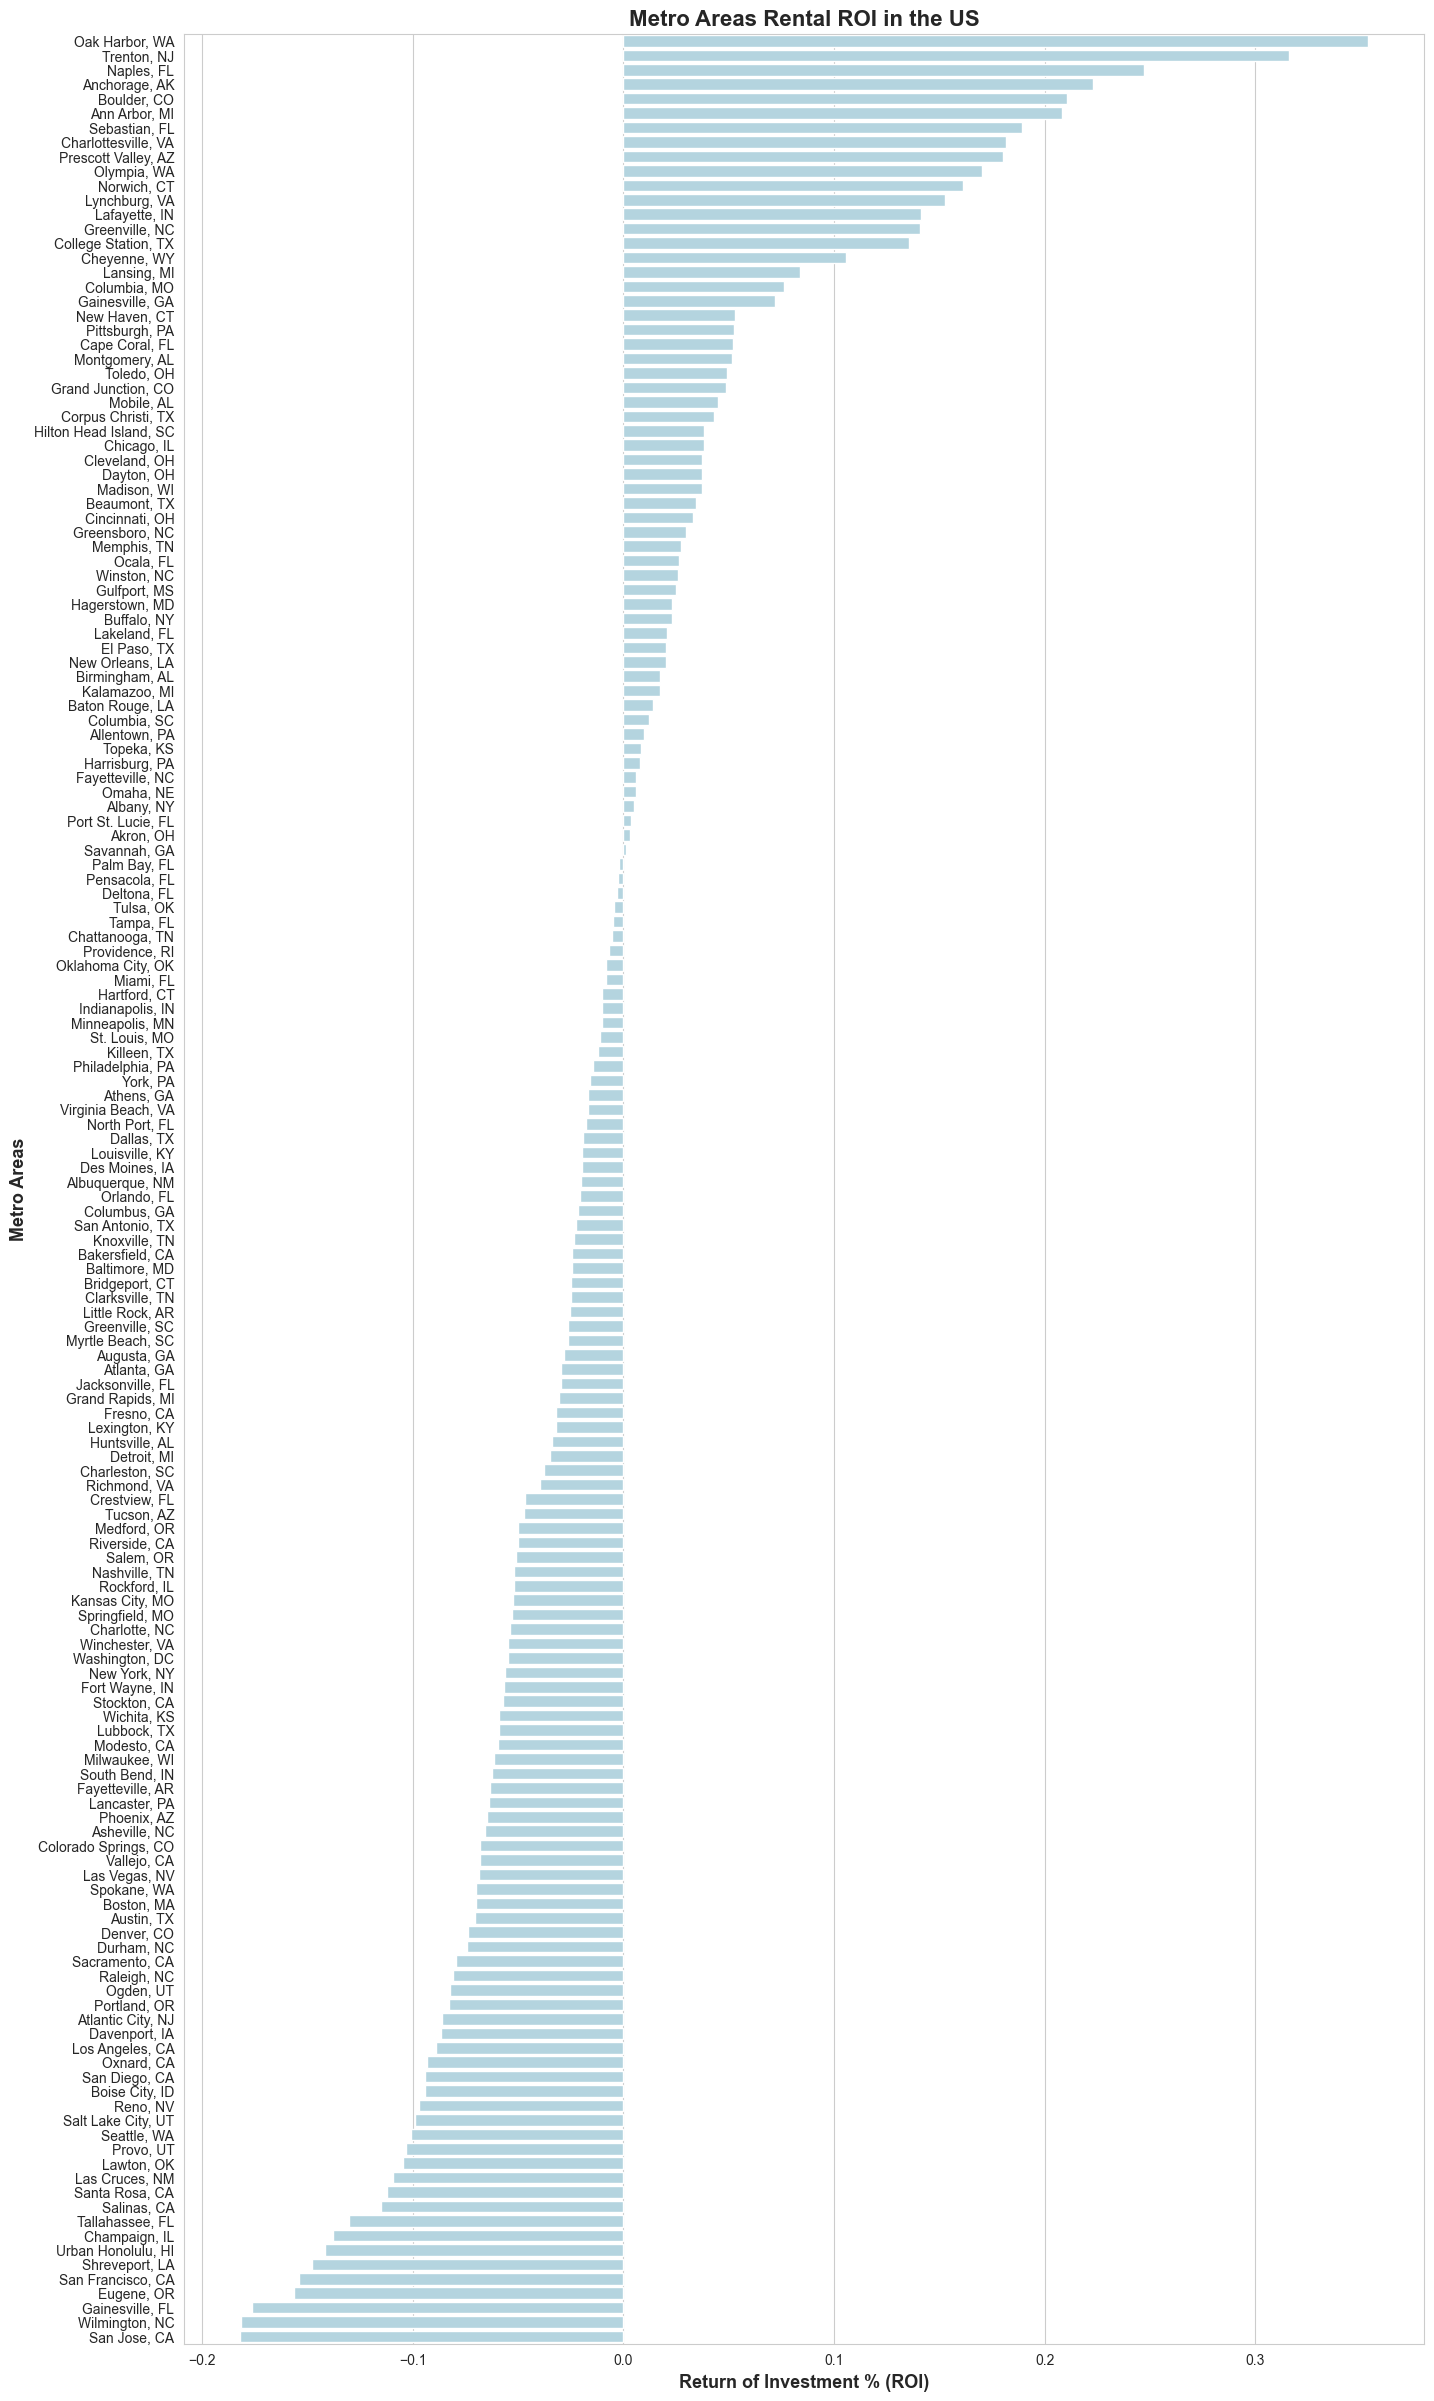

In [74]:
#Horizontal barchart
#Create subplot
sns.set_style('whitegrid')
fig,ax=plt.subplots(figsize=(16,30))

#Create barplot
chart1 = sns.barplot(x=df_merged['ROI_rental'], y = df_merged['Metro_Area'],color='lightblue')
chart1.set_title('Metro Areas Rental ROI in the US',weight='bold',fontsize=16)

chart1.set_xlabel('Return of Investment % (ROI)',weight = 'bold',fontsize = 13)
chart1.set_ylabel('Metro Areas', weight='bold',fontsize=13)

display(df_merged)

## Conclusions for ROI in rental in metro areas: 
1. Among 389 metro areas in the US, Oak Harbor, Washington has as high as 35% rental ROI in the past 5 years.
2. San Jose has the lowest rental ROI, around negative 18% in metro areas

## 2. What are the ROI in rental look like in four regions?

In [75]:
# Add a "Region" column

# Define the regions
northeast = ["CT", "ME", "MA", "NH", "RI", "VT", "NJ", "NY", "PA"]
midwest = ["IL", "IN", "IA", "KS", "MI", "MN", "MO", "NE", "ND", "OH", "SD", "WI"]
south = ["AL", "AR", "DE", "FL", "GA", "KY", "LA", "MD", "MS", "NC", "OK", "SC", "TN", "TX", "VA", "WV"]
west = ["AK", "AZ", "CA", "CO", "HI", "ID", "MT", "NV", "NM", "OR", "UT", "WA", "WY"]

# Map states to regions
region_map = {}
region_map.update({state: "northeast" for state in northeast})
region_map.update({state: "midwest" for state in midwest})
region_map.update({state: "south" for state in south})
region_map.update({state: "west" for state in west})

display(region_map)

# Add the Region column
df_merged.insert(1, "Region", df["state_name"].map(region_map))
df_merged["state_name"] = df["state_name"]
df_merged.head(5)

{'CT': 'northeast',
 'ME': 'northeast',
 'MA': 'northeast',
 'NH': 'northeast',
 'RI': 'northeast',
 'VT': 'northeast',
 'NJ': 'northeast',
 'NY': 'northeast',
 'PA': 'northeast',
 'IL': 'midwest',
 'IN': 'midwest',
 'IA': 'midwest',
 'KS': 'midwest',
 'MI': 'midwest',
 'MN': 'midwest',
 'MO': 'midwest',
 'NE': 'midwest',
 'ND': 'midwest',
 'OH': 'midwest',
 'SD': 'midwest',
 'WI': 'midwest',
 'AL': 'south',
 'AR': 'south',
 'DE': 'south',
 'FL': 'south',
 'GA': 'south',
 'KY': 'south',
 'LA': 'south',
 'MD': 'south',
 'MS': 'south',
 'NC': 'south',
 'OK': 'south',
 'SC': 'south',
 'TN': 'south',
 'TX': 'south',
 'VA': 'south',
 'WV': 'south',
 'AK': 'west',
 'AZ': 'west',
 'CA': 'west',
 'CO': 'west',
 'HI': 'west',
 'ID': 'west',
 'MT': 'west',
 'NV': 'west',
 'NM': 'west',
 'OR': 'west',
 'UT': 'west',
 'WA': 'west',
 'WY': 'west'}

,Metro_Area,Region,Monthly_Rent,Sale_Price,ROI_rental,state_name
389,"Oak Harbor, WA",midwest,2527.425926,177500.0,0.353339,OH
141,"Trenton, NJ",south,2714.824074,203000.0,0.316129,AL
146,"Naples, FL",midwest,4595.913778,391500.0,0.246949,MI
138,"Anchorage, AK",south,2423.849624,213963.0,0.223106,TX
155,"Boulder, CO",midwest,3191.399611,289950.0,0.210824,WI


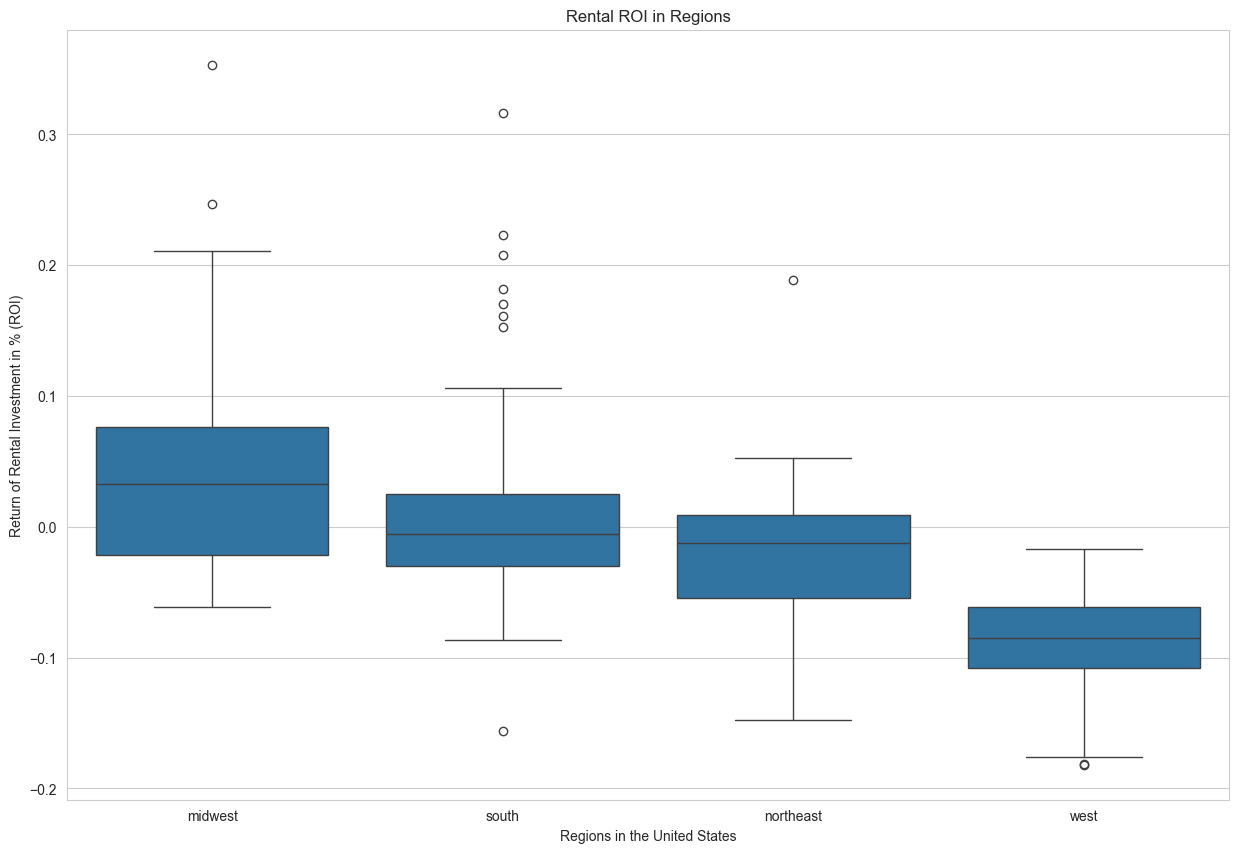

In [76]:
# Create box plots for ROI_rental by region
fig, axes = plt.subplots(figsize=(15, 10))

sns.boxplot(x='Region', y='ROI_rental', data=df_merged)
axes.set_title('Rental ROI in Regions')
axes.set_xlabel('Regions in the United States')
axes.set_ylabel('Return of Rental Investment in % (ROI)')
plt.show()

## Conclusions for Box Plots: 
1. Compared to the other regions, Midwest has the highest rental ROI, with the average of 5%. Midwest also has the largest ROI rental differences in the past 5 years. So if you plan to invest in the southern states, you need use the Horizontal Bar Chart to do a more detailed investigation to see which state is worth to invest first.
2. Although Oak Harbor in Washington has as high as 35% ROI in rental properties, the average rental investment in West states are the lowest, with the average of -9% ROI in rental.
3. Except for some metro areas, being a landlord in the other regions is generally not a good idea, as the average rental ROI are all negative. 

## 3. How to invest in different regions with the comparison of ROI in selling?

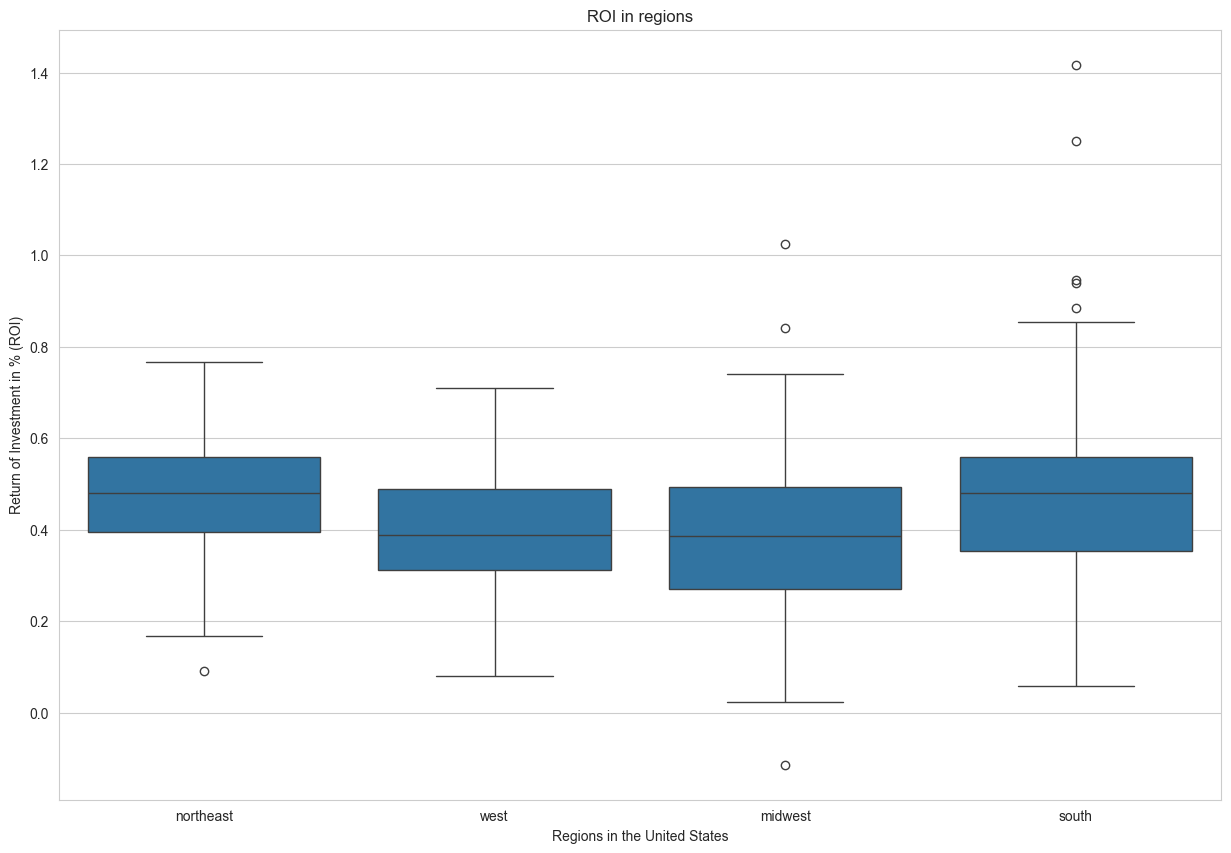

In [77]:
# Compare with the Sale ROI in Regions
fig, axes = plt.subplots(figsize=(15, 10))

sns.boxplot(x='region', y='ROI', data=df)
axes.set_title('ROI in regions')
axes.set_xlabel('Regions in the United States')
axes.set_ylabel('Return of Investment in % (ROI)')
plt.show()

## Conclusions for comparing ROI in Selling vs ROI in Rental in Four Regions: 
1. By looking at these 2 box plot charts together, we found states in the Midwest, like Minnesota, are the best places to purchase a property and rent out, instead of flipping and then selling in the past 5 years. 
2. Although being a landlord in the regions, expect for the midwest might not be a good idea. Selling houses in the Northeast, South and even West states has a pretty good amount of profits comparing to rent houses out.

## 4. After comparing four regions, we dig deeper to find which states are worthy to rent properties out:

In [78]:
# ??? This is the place didn't work this afternoon. Thank you! 
## Create a pivot table for ROI_rental: 
display(df_merged.head(5))
pivot3 = df_merged.pivot_table(index='state_name', values='ROI_rental', aggfunc='mean')
pivot3 = pivot3.sort_values(by='ROI_rental', ascending=False)
display(pivot3)

,Metro_Area,Region,Monthly_Rent,Sale_Price,ROI_rental,state_name
389,"Oak Harbor, WA",midwest,2527.425926,177500.0,0.353339,OH
141,"Trenton, NJ",south,2714.824074,203000.0,0.316129,AL
146,"Naples, FL",midwest,4595.913778,391500.0,0.246949,MI
138,"Anchorage, AK",south,2423.849624,213963.0,0.223106,TX
155,"Boulder, CO",midwest,3191.399611,289950.0,0.210824,WI


,ROI_rental
state_name,
WV,0.152478
AL,0.086099
OH,0.085604
IL,0.076790
MI,0.075015
LA,0.062519
WI,0.062278
KS,0.060675
IA,0.060505


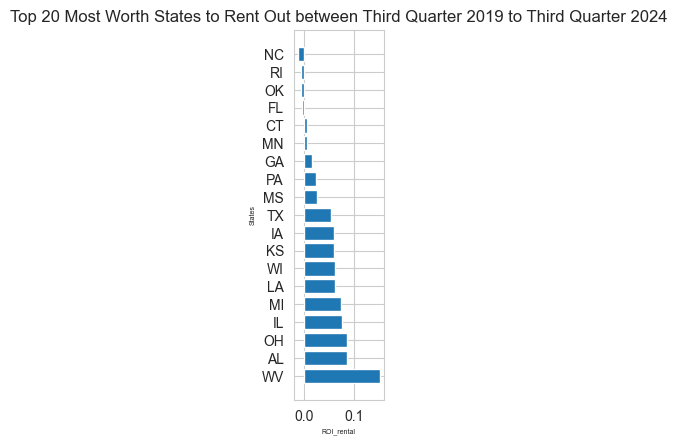

In [79]:
#Read data from pivot3
pivot3_top20 = pivot3[:19]
plt.subplot(1,4,1)
plt.barh(pivot3_top20.index,pivot3_top20['ROI_rental'])
plt.title('Top 20 Most Worth States to Rent Out between Third Quarter 2019 to Third Quarter 2024')
plt.xlabel('ROI_rental',fontsize=5)
plt.ylabel('States',fontsize=5)
plt.subplots_adjust(wspace=.5, hspace=.5)

,ROI
state_name,
LA,0.186154
ND,0.217978
IL,0.219843
WV,0.285849
IA,0.288536
WY,0.298295
CA,0.301775
OK,0.306074
MS,0.327174


Text(0, 0.5, 'Regions')

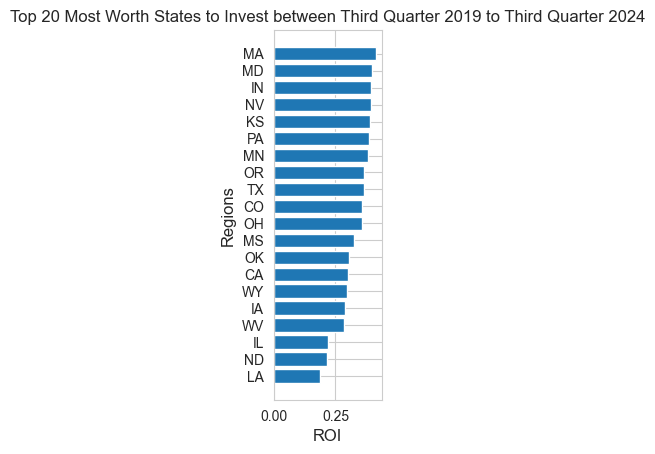

In [80]:
#Table for Top 20 ROI: 
pivot = df.pivot_table(index = ['state_name'],values = ['ROI'])
pivot = pivot.sort_values(by = 'ROI', ascending = True).head(20)
display(pivot)

#Chart for Top 20 ROI:
plt.subplot(1,4,1)
plt.barh(pivot.index,pivot['ROI'])
plt.title('Top 20 Most Worth States to Invest between Third Quarter 2019 to Third Quarter 2024')
plt.xlabel('ROI',fontsize=12)
plt.ylabel('Regions',fontsize=12)

In [81]:
# Create a pivot table for ROI_rental: 
pivot3 = df_merged.pivot_table(index = ['state_name'],values = ['ROI_rental'])
pivot3 = pivot3.sort_values(by = 'ROI_rental', ascending = False).tail(20)
display(pivot3)

,ROI_rental
state_name,
MD,-0.024629
KY,-0.025882
SC,-0.028096
VA,-0.029014
IN,-0.029470
NY,-0.033236
MO,-0.038920
AZ,-0.042971
AR,-0.044526


## Conclusions for pivot tables and bar charts: 
1. Among the top 20 highest rental_roi states, West Virgina is has the highest rental roi, which is about 15%.
2. New Jersey is the worst place to rent, with negative 14% rental ROI